In [1]:
from model.roberta import roberta_sum_classifier
from model.roberta import roberta_pool_classifier
from model.bert import bert_classifier
from model.xlnet import xlnet_classifier

from data.class_dataset import dataset

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
import time
import numpy as np
import pandas as pd

import torch
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Model

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NAME = "xlnet-base-cased"
NUM_LABLES = 3
MODEL = xlnet_classifier(3, NAME).to(DEVICE)
TOKENIZER = MODEL.get_tokenizer()
LOSS_FN = nn.CrossEntropyLoss().to(DEVICE)
OPTIMIZER = torch.optim.Adam(MODEL.parameters(), lr=2e-5)

# Dataset

In [5]:
def draw_df_label(df, name):
    ax = df['truth'].value_counts(sort=False).plot(kind="barh")
    ax.set_xlabel(name)
    ax.set_ylabel("Label")

In [6]:
# amazon_20201210_test_set = dataset(path="amazon5_20201210_body_test.csv", tokenizer=TOKENIZER)
# amazon_20201210_train_set = dataset(path="amazon5_20201210_body_train.csv", tokenizer=TOKENIZER)
# draw_df_label(amazon_20201210_train_set.get_df(), amazon_20201210_train_set.get_name())
# amazon_20201210_train_set.get_df().head()

Size : 2210
Size : 8544


,truth,text
0,2,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,2,Singer/composer Bryan Adams contributes a slew...
3,1,You 'd think by now America would have had eno...
4,2,Yet the act is still charming here .


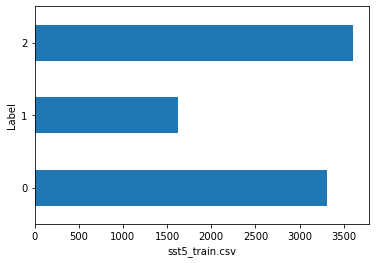

In [7]:
sst5_test_set = dataset(path='data/sst5_test.csv', tokenizer=TOKENIZER)
sst5_train_set = dataset(path='data/sst5_train.csv', tokenizer=TOKENIZER)
draw_df_label(sst5_train_set.get_df(), sst5_train_set.get_name())
sst5_train_set.get_df().head()

In [8]:
# balance_set = dataset(path='amazon5_e_temp.csv', tokenizer=tokenizer)
# draw_df_label(balance_set.get_df(), balance_set.get_name())

In [9]:
# train_set = ConcatDataset([amazon_20201210_train_set, sst5_train_set, balance_set])
train_set = sst5_train_set
print(TOKENIZER.convert_ids_to_tokens(train_set.__getitem__(133)[0]))

['<cls>', '▁Miller', '▁tells', '▁this', '▁very', '▁compelling', '▁tale', '▁with', '▁little', '▁fuss', '▁or', '▁noise', '▁', ',', '▁expert', 'ly', '▁pluck', 'ing', '▁tension', '▁from', '▁quiet', '▁', '.']


In [10]:
def train(loader, epochs):
    all_data = len(loader)
    for epoch in range(epochs):
        finish_data = 0
        losses = []
        current_times = []
        correct_predictions = 0
        
        for data in loader:
            MODEL.train()
            t0 = time.time()
            
            ids_tensors, masks_tensors, labels = [t.to(DEVICE) for t in data]

            outputs = MODEL(input_ids=ids_tensors,  attention_mask=masks_tensors)
            
            loss = LOSS_FN(outputs, labels.type(torch.LongTensor).to(DEVICE))
            losses.append(loss.item())
            
            loss.backward()
            
            OPTIMIZER.step()
            OPTIMIZER.zero_grad()
            
            finish_data += 1
            current_times.append(round(time.time()-t0,3))
            current = np.mean(current_times)
            hr, min, sec = evl_time(current*(all_data-finish_data) + current*all_data*(epochs-epoch-1) + current/2*all_data*(epochs-epoch-1))
            print('epoch:', epoch, " batch:", finish_data, "/" , all_data, " loss:", np.mean(losses), " hr:", hr, " min:", min," sec:", sec)         

        save_model("train-epoch-"+NAME+'.pkl')
        x, y = test(loader)
        print(classification_report(x, y, target_names=[str(i) for i in range(NUM_LABLES)]))

In [11]:
def test(loader):
    MODEL.eval()
    pred = []
    trueth = []
    with torch.no_grad():
        for data in loader:
            ids_tensors, masks_tensors, labels = [t.to(DEVICE) for t in data]
            outputs = MODEL(input_ids=ids_tensors,  attention_mask=masks_tensors)
            _, predictions = torch.max(outputs, dim=1)

            pred += list([int(i) for i in predictions])
            trueth += list([int(i) for i in labels])

    return trueth, pred

In [12]:
def load_model(path):
    MODEL.load_state_dict(torch.load(path), strict=False)
    
def save_model(name):
    torch.save(MODEL.state_dict(), name)

def predict(sentence, tokenizer):
    MODEL.eval()
    word_pieces = [tokenizer.cls_token]
    tokens = tokenizer.tokenize(sentence)
    if len(tokens) > 500:
        tokens = tokens[:200] + tokens[-300:]
    word_pieces += tokens
    ids = tokenizer.convert_tokens_to_ids(word_pieces)
    input_tensor = torch.tensor([ids]).to(DEVICE)

    with torch.no_grad():
        outputs = MODEL(input_tensor)
        _, predictions = torch.max(outputs, dim=1)
    
    return predictions, outputs

def evl_time(t):
    min, sec= divmod(t, 60)
    hr, min = divmod(min, 60)
    return int(hr), int(min), int(sec)

def create_mini_batch(samples):
    ids_tensors = [s[0] for s in samples]
    ids_tensors = pad_sequence(ids_tensors, batch_first=True)

    label_ids = torch.stack([s[1] for s in samples])
    
    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)
    
    return ids_tensors, masks_tensors, label_ids

def draw_c_matrix(c_matrix, title="test"):
    aix = []
    for y in range(len(c_matrix)):
        aix.append(y)
    df_cm = pd.DataFrame(c_matrix, aix, aix)
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel("prediction")
    plt.xlabel("ground truth")
    plt.title(title)
    plt.savefig(title+'.jpg')
    plt.show()

# train

In [13]:
train_loader = DataLoader(train_set, batch_size=5, collate_fn=create_mini_batch, shuffle = True)

In [14]:
%time train(train_loader, 6)
save_model('3-sst5-'+NAME+'.pkl')

epoch: 0  batch: 1 / 1709  loss: 1.281149983406067  hr: 1  min: 50  sec: 23
epoch: 0  batch: 2 / 1709  loss: 1.261227011680603  hr: 1  min: 5  sec: 28
epoch: 0  batch: 3 / 1709  loss: 1.1202370127042134  hr: 0  min: 50  sec: 45
epoch: 0  batch: 4 / 1709  loss: 1.8841837495565414  hr: 0  min: 42  sec: 46
epoch: 0  batch: 5 / 1709  loss: 1.7791383624076844  hr: 0  min: 38  sec: 8
epoch: 0  batch: 6 / 1709  loss: 1.7189543346563976  hr: 0  min: 35  sec: 24
epoch: 0  batch: 7 / 1709  loss: 1.626064462321145  hr: 0  min: 33  sec: 13
epoch: 0  batch: 8 / 1709  loss: 1.548438511788845  hr: 0  min: 32  sec: 18
epoch: 0  batch: 9 / 1709  loss: 1.5466077129046123  hr: 0  min: 31  sec: 3
epoch: 0  batch: 10 / 1709  loss: 1.5118508279323577  hr: 0  min: 30  sec: 7
epoch: 0  batch: 11 / 1709  loss: 1.4490988417105242  hr: 0  min: 29  sec: 19
epoch: 0  batch: 12 / 1709  loss: 1.4026339153448741  hr: 0  min: 28  sec: 32
epoch: 0  batch: 13 / 1709  loss: 1.3581019502419691  hr: 0  min: 27  sec: 54
epo

epoch: 0  batch: 107 / 1709  loss: 1.0054217057528896  hr: 0  min: 20  sec: 37
epoch: 0  batch: 108 / 1709  loss: 1.0121810517653271  hr: 0  min: 20  sec: 38
epoch: 0  batch: 109 / 1709  loss: 1.0137775014026449  hr: 0  min: 20  sec: 38
epoch: 0  batch: 110 / 1709  loss: 1.0168535279956732  hr: 0  min: 20  sec: 39
epoch: 0  batch: 111 / 1709  loss: 1.0130340015297536  hr: 0  min: 20  sec: 40
epoch: 0  batch: 112 / 1709  loss: 1.0177317042169827  hr: 0  min: 20  sec: 40
epoch: 0  batch: 113 / 1709  loss: 1.0203981614482087  hr: 0  min: 20  sec: 40
epoch: 0  batch: 114 / 1709  loss: 1.0193574359281021  hr: 0  min: 20  sec: 41
epoch: 0  batch: 115 / 1709  loss: 1.0195429619239724  hr: 0  min: 20  sec: 40
epoch: 0  batch: 116 / 1709  loss: 1.0174523657508965  hr: 0  min: 20  sec: 39
epoch: 0  batch: 117 / 1709  loss: 1.0146687065179532  hr: 0  min: 20  sec: 38
epoch: 0  batch: 118 / 1709  loss: 1.0131910830988722  hr: 0  min: 20  sec: 38
epoch: 0  batch: 119 / 1709  loss: 1.013186656502114

epoch: 0  batch: 213 / 1709  loss: 0.9157254169104805  hr: 0  min: 19  sec: 56
epoch: 0  batch: 214 / 1709  loss: 0.9159268931111443  hr: 0  min: 19  sec: 55
epoch: 0  batch: 215 / 1709  loss: 0.9149280630571898  hr: 0  min: 19  sec: 54
epoch: 0  batch: 216 / 1709  loss: 0.9141080632667851  hr: 0  min: 19  sec: 55
epoch: 0  batch: 217 / 1709  loss: 0.91407883352673  hr: 0  min: 19  sec: 54
epoch: 0  batch: 218 / 1709  loss: 0.9139234688167178  hr: 0  min: 19  sec: 54
epoch: 0  batch: 219 / 1709  loss: 0.912462484006468  hr: 0  min: 19  sec: 53
epoch: 0  batch: 220 / 1709  loss: 0.9104481616480784  hr: 0  min: 19  sec: 53
epoch: 0  batch: 221 / 1709  loss: 0.9079393430937469  hr: 0  min: 19  sec: 53
epoch: 0  batch: 222 / 1709  loss: 0.9064535100583557  hr: 0  min: 19  sec: 52
epoch: 0  batch: 223 / 1709  loss: 0.9064951912570962  hr: 0  min: 19  sec: 52
epoch: 0  batch: 224 / 1709  loss: 0.9047611945840929  hr: 0  min: 19  sec: 51
epoch: 0  batch: 225 / 1709  loss: 0.9054067616330252  

epoch: 0  batch: 317 / 1709  loss: 0.8392364838945001  hr: 0  min: 19  sec: 38
epoch: 0  batch: 318 / 1709  loss: 0.8388014013334265  hr: 0  min: 19  sec: 38
epoch: 0  batch: 319 / 1709  loss: 0.8370690378696194  hr: 0  min: 19  sec: 37
epoch: 0  batch: 320 / 1709  loss: 0.8357391325058415  hr: 0  min: 19  sec: 37
epoch: 0  batch: 321 / 1709  loss: 0.8364057668319372  hr: 0  min: 19  sec: 37
epoch: 0  batch: 322 / 1709  loss: 0.8359724428759229  hr: 0  min: 19  sec: 37
epoch: 0  batch: 323 / 1709  loss: 0.8355814535228461  hr: 0  min: 19  sec: 36
epoch: 0  batch: 324 / 1709  loss: 0.8366307192424565  hr: 0  min: 19  sec: 37
epoch: 0  batch: 325 / 1709  loss: 0.8375045885718786  hr: 0  min: 19  sec: 36
epoch: 0  batch: 326 / 1709  loss: 0.8398871391874515  hr: 0  min: 19  sec: 36
epoch: 0  batch: 327 / 1709  loss: 0.8381719714321128  hr: 0  min: 19  sec: 36
epoch: 0  batch: 328 / 1709  loss: 0.8373403103295259  hr: 0  min: 19  sec: 36
epoch: 0  batch: 329 / 1709  loss: 0.837554674131348

epoch: 0  batch: 422 / 1709  loss: 0.8317846541615177  hr: 0  min: 19  sec: 26
epoch: 0  batch: 423 / 1709  loss: 0.8316473706006722  hr: 0  min: 19  sec: 26
epoch: 0  batch: 424 / 1709  loss: 0.8323290954115536  hr: 0  min: 19  sec: 26
epoch: 0  batch: 425 / 1709  loss: 0.8321803105754011  hr: 0  min: 19  sec: 26
epoch: 0  batch: 426 / 1709  loss: 0.8310349914004825  hr: 0  min: 19  sec: 25
epoch: 0  batch: 427 / 1709  loss: 0.8309086721905221  hr: 0  min: 19  sec: 25
epoch: 0  batch: 428 / 1709  loss: 0.8315735277066999  hr: 0  min: 19  sec: 25
epoch: 0  batch: 429 / 1709  loss: 0.8298227833909588  hr: 0  min: 19  sec: 25
epoch: 0  batch: 430 / 1709  loss: 0.8293650072327879  hr: 0  min: 19  sec: 26
epoch: 0  batch: 431 / 1709  loss: 0.8285882032180331  hr: 0  min: 19  sec: 26
epoch: 0  batch: 432 / 1709  loss: 0.8278800501936564  hr: 0  min: 19  sec: 26
epoch: 0  batch: 433 / 1709  loss: 0.8279122497206748  hr: 0  min: 19  sec: 25
epoch: 0  batch: 434 / 1709  loss: 0.827926579467986

epoch: 0  batch: 526 / 1709  loss: 0.8175920067008003  hr: 0  min: 19  sec: 17
epoch: 0  batch: 527 / 1709  loss: 0.8171286141001523  hr: 0  min: 19  sec: 17
epoch: 0  batch: 528 / 1709  loss: 0.816371845504777  hr: 0  min: 19  sec: 17
epoch: 0  batch: 529 / 1709  loss: 0.8163248380832726  hr: 0  min: 19  sec: 17
epoch: 0  batch: 530 / 1709  loss: 0.8164520261703797  hr: 0  min: 19  sec: 17
epoch: 0  batch: 531 / 1709  loss: 0.8170231421620159  hr: 0  min: 19  sec: 17
epoch: 0  batch: 532 / 1709  loss: 0.8179117454902122  hr: 0  min: 19  sec: 17
epoch: 0  batch: 533 / 1709  loss: 0.8170650988593557  hr: 0  min: 19  sec: 17
epoch: 0  batch: 534 / 1709  loss: 0.8180506750941277  hr: 0  min: 19  sec: 17
epoch: 0  batch: 535 / 1709  loss: 0.8177613254183921  hr: 0  min: 19  sec: 17
epoch: 0  batch: 536 / 1709  loss: 0.817539650474244  hr: 0  min: 19  sec: 17
epoch: 0  batch: 537 / 1709  loss: 0.8179587555608714  hr: 0  min: 19  sec: 17
epoch: 0  batch: 538 / 1709  loss: 0.8169877704468358 

epoch: 0  batch: 633 / 1709  loss: 0.80085354071187  hr: 0  min: 19  sec: 8
epoch: 0  batch: 634 / 1709  loss: 0.8012076732629105  hr: 0  min: 19  sec: 9
epoch: 0  batch: 635 / 1709  loss: 0.8000900773668852  hr: 0  min: 19  sec: 9
epoch: 0  batch: 636 / 1709  loss: 0.7992602398021603  hr: 0  min: 19  sec: 9
epoch: 0  batch: 637 / 1709  loss: 0.7981314213604344  hr: 0  min: 19  sec: 9
epoch: 0  batch: 638 / 1709  loss: 0.7975921631676837  hr: 0  min: 19  sec: 9
epoch: 0  batch: 639 / 1709  loss: 0.7977643713401703  hr: 0  min: 19  sec: 9
epoch: 0  batch: 640 / 1709  loss: 0.7967707591480575  hr: 0  min: 19  sec: 10
epoch: 0  batch: 641 / 1709  loss: 0.7968341903804617  hr: 0  min: 19  sec: 10
epoch: 0  batch: 642 / 1709  loss: 0.7958909843082183  hr: 0  min: 19  sec: 10
epoch: 0  batch: 643 / 1709  loss: 0.7967159738691747  hr: 0  min: 19  sec: 10
epoch: 0  batch: 644 / 1709  loss: 0.7965698330923452  hr: 0  min: 19  sec: 10
epoch: 0  batch: 645 / 1709  loss: 0.7966140900355901  hr: 0 

epoch: 0  batch: 739 / 1709  loss: 0.7786687479048201  hr: 0  min: 19  sec: 3
epoch: 0  batch: 740 / 1709  loss: 0.778933034837246  hr: 0  min: 19  sec: 3
epoch: 0  batch: 741 / 1709  loss: 0.7786553692318972  hr: 0  min: 19  sec: 3
epoch: 0  batch: 742 / 1709  loss: 0.7784598001813632  hr: 0  min: 19  sec: 3
epoch: 0  batch: 743 / 1709  loss: 0.7791811891632157  hr: 0  min: 19  sec: 3
epoch: 0  batch: 744 / 1709  loss: 0.7792918193804962  hr: 0  min: 19  sec: 3
epoch: 0  batch: 745 / 1709  loss: 0.778728030912028  hr: 0  min: 19  sec: 3
epoch: 0  batch: 746 / 1709  loss: 0.7785913080536329  hr: 0  min: 19  sec: 3
epoch: 0  batch: 747 / 1709  loss: 0.7782970595072551  hr: 0  min: 19  sec: 3
epoch: 0  batch: 748 / 1709  loss: 0.7781636651983873  hr: 0  min: 19  sec: 2
epoch: 0  batch: 749 / 1709  loss: 0.7780910568816639  hr: 0  min: 19  sec: 2
epoch: 0  batch: 750 / 1709  loss: 0.7786031603018443  hr: 0  min: 19  sec: 2
epoch: 0  batch: 751 / 1709  loss: 0.7780539522793258  hr: 0  min:

epoch: 0  batch: 845 / 1709  loss: 0.768201080872815  hr: 0  min: 18  sec: 57
epoch: 0  batch: 846 / 1709  loss: 0.7681739343766202  hr: 0  min: 18  sec: 57
epoch: 0  batch: 847 / 1709  loss: 0.7678237760169024  hr: 0  min: 18  sec: 57
epoch: 0  batch: 848 / 1709  loss: 0.7673744453943141  hr: 0  min: 18  sec: 57
epoch: 0  batch: 849 / 1709  loss: 0.7672904242703295  hr: 0  min: 18  sec: 57
epoch: 0  batch: 850 / 1709  loss: 0.7675023942922845  hr: 0  min: 18  sec: 57
epoch: 0  batch: 851 / 1709  loss: 0.7679367446538704  hr: 0  min: 18  sec: 56
epoch: 0  batch: 852 / 1709  loss: 0.7675945678804542  hr: 0  min: 18  sec: 56
epoch: 0  batch: 853 / 1709  loss: 0.7672280478187491  hr: 0  min: 18  sec: 56
epoch: 0  batch: 854 / 1709  loss: 0.766690445352843  hr: 0  min: 18  sec: 56
epoch: 0  batch: 855 / 1709  loss: 0.7670848873362207  hr: 0  min: 18  sec: 56
epoch: 0  batch: 856 / 1709  loss: 0.7671832655095191  hr: 0  min: 18  sec: 56
epoch: 0  batch: 857 / 1709  loss: 0.767590240087434  

epoch: 0  batch: 950 / 1709  loss: 0.7608511192155512  hr: 0  min: 18  sec: 50
epoch: 0  batch: 951 / 1709  loss: 0.7607075468207133  hr: 0  min: 18  sec: 50
epoch: 0  batch: 952 / 1709  loss: 0.7603402516155058  hr: 0  min: 18  sec: 50
epoch: 0  batch: 953 / 1709  loss: 0.7597479576094454  hr: 0  min: 18  sec: 50
epoch: 0  batch: 954 / 1709  loss: 0.7603621265189078  hr: 0  min: 18  sec: 50
epoch: 0  batch: 955 / 1709  loss: 0.76005009419787  hr: 0  min: 18  sec: 50
epoch: 0  batch: 956 / 1709  loss: 0.7601131190269188  hr: 0  min: 18  sec: 50
epoch: 0  batch: 957 / 1709  loss: 0.7596603116972319  hr: 0  min: 18  sec: 50
epoch: 0  batch: 958 / 1709  loss: 0.7600277246117965  hr: 0  min: 18  sec: 50
epoch: 0  batch: 959 / 1709  loss: 0.7601814902813889  hr: 0  min: 18  sec: 50
epoch: 0  batch: 960 / 1709  loss: 0.7599320178308214  hr: 0  min: 18  sec: 50
epoch: 0  batch: 961 / 1709  loss: 0.7598083442334826  hr: 0  min: 18  sec: 50
epoch: 0  batch: 962 / 1709  loss: 0.7596634262146549 

epoch: 0  batch: 1054 / 1709  loss: 0.760453820108406  hr: 0  min: 18  sec: 44
epoch: 0  batch: 1055 / 1709  loss: 0.7602594760851272  hr: 0  min: 18  sec: 44
epoch: 0  batch: 1056 / 1709  loss: 0.760210273441661  hr: 0  min: 18  sec: 44
epoch: 0  batch: 1057 / 1709  loss: 0.7602556797771828  hr: 0  min: 18  sec: 44
epoch: 0  batch: 1058 / 1709  loss: 0.7600117687396494  hr: 0  min: 18  sec: 43
epoch: 0  batch: 1059 / 1709  loss: 0.759944051862945  hr: 0  min: 18  sec: 43
epoch: 0  batch: 1060 / 1709  loss: 0.7593688845845326  hr: 0  min: 18  sec: 43
epoch: 0  batch: 1061 / 1709  loss: 0.7590323327834262  hr: 0  min: 18  sec: 43
epoch: 0  batch: 1062 / 1709  loss: 0.7592738302961245  hr: 0  min: 18  sec: 43
epoch: 0  batch: 1063 / 1709  loss: 0.7593859280139796  hr: 0  min: 18  sec: 43
epoch: 0  batch: 1064 / 1709  loss: 0.7590810621745492  hr: 0  min: 18  sec: 43
epoch: 0  batch: 1065 / 1709  loss: 0.7588818414040575  hr: 0  min: 18  sec: 42
epoch: 0  batch: 1066 / 1709  loss: 0.75884

epoch: 0  batch: 1157 / 1709  loss: 0.7469589140655774  hr: 0  min: 18  sec: 34
epoch: 0  batch: 1158 / 1709  loss: 0.7478180539203946  hr: 0  min: 18  sec: 34
epoch: 0  batch: 1159 / 1709  loss: 0.7476873773956114  hr: 0  min: 18  sec: 34
epoch: 0  batch: 1160 / 1709  loss: 0.7473342606926273  hr: 0  min: 18  sec: 34
epoch: 0  batch: 1161 / 1709  loss: 0.7473287711451014  hr: 0  min: 18  sec: 34
epoch: 0  batch: 1162 / 1709  loss: 0.7469309136951133  hr: 0  min: 18  sec: 34
epoch: 0  batch: 1163 / 1709  loss: 0.7468082214916255  hr: 0  min: 18  sec: 34
epoch: 0  batch: 1164 / 1709  loss: 0.7465756408217334  hr: 0  min: 18  sec: 34
epoch: 0  batch: 1165 / 1709  loss: 0.7461814407818819  hr: 0  min: 18  sec: 34
epoch: 0  batch: 1166 / 1709  loss: 0.7463104533379831  hr: 0  min: 18  sec: 34
epoch: 0  batch: 1167 / 1709  loss: 0.7465748587414149  hr: 0  min: 18  sec: 34
epoch: 0  batch: 1168 / 1709  loss: 0.7465083478847901  hr: 0  min: 18  sec: 34
epoch: 0  batch: 1169 / 1709  loss: 0.74

epoch: 0  batch: 1261 / 1709  loss: 0.7375592775642872  hr: 0  min: 18  sec: 26
epoch: 0  batch: 1262 / 1709  loss: 0.7381301538815069  hr: 0  min: 18  sec: 26
epoch: 0  batch: 1263 / 1709  loss: 0.7379758645436024  hr: 0  min: 18  sec: 26
epoch: 0  batch: 1264 / 1709  loss: 0.738033318399935  hr: 0  min: 18  sec: 26
epoch: 0  batch: 1265 / 1709  loss: 0.7382108999835879  hr: 0  min: 18  sec: 26
epoch: 0  batch: 1266 / 1709  loss: 0.7377915084979969  hr: 0  min: 18  sec: 26
epoch: 0  batch: 1267 / 1709  loss: 0.737755019846942  hr: 0  min: 18  sec: 26
epoch: 0  batch: 1268 / 1709  loss: 0.7374780812809003  hr: 0  min: 18  sec: 25
epoch: 0  batch: 1269 / 1709  loss: 0.7373468222682217  hr: 0  min: 18  sec: 25
epoch: 0  batch: 1270 / 1709  loss: 0.7375878556184178  hr: 0  min: 18  sec: 25
epoch: 0  batch: 1271 / 1709  loss: 0.7376012326746499  hr: 0  min: 18  sec: 25
epoch: 0  batch: 1272 / 1709  loss: 0.7376615287613053  hr: 0  min: 18  sec: 25
epoch: 0  batch: 1273 / 1709  loss: 0.7377

epoch: 0  batch: 1364 / 1709  loss: 0.7315572929374677  hr: 0  min: 18  sec: 19
epoch: 0  batch: 1365 / 1709  loss: 0.7317117419025618  hr: 0  min: 18  sec: 18
epoch: 0  batch: 1366 / 1709  loss: 0.731252335778289  hr: 0  min: 18  sec: 18
epoch: 0  batch: 1367 / 1709  loss: 0.73097466213878  hr: 0  min: 18  sec: 18
epoch: 0  batch: 1368 / 1709  loss: 0.7309216830296692  hr: 0  min: 18  sec: 18
epoch: 0  batch: 1369 / 1709  loss: 0.7307990412721023  hr: 0  min: 18  sec: 18
epoch: 0  batch: 1370 / 1709  loss: 0.7306157087023458  hr: 0  min: 18  sec: 18
epoch: 0  batch: 1371 / 1709  loss: 0.7306191749207779  hr: 0  min: 18  sec: 18
epoch: 0  batch: 1372 / 1709  loss: 0.7304467995170472  hr: 0  min: 18  sec: 18
epoch: 0  batch: 1373 / 1709  loss: 0.7304728379458167  hr: 0  min: 18  sec: 18
epoch: 0  batch: 1374 / 1709  loss: 0.7302108823607799  hr: 0  min: 18  sec: 19
epoch: 0  batch: 1375 / 1709  loss: 0.7304846473309127  hr: 0  min: 18  sec: 19
epoch: 0  batch: 1376 / 1709  loss: 0.73030

epoch: 0  batch: 1469 / 1709  loss: 0.7262586977857769  hr: 0  min: 18  sec: 12
epoch: 0  batch: 1470 / 1709  loss: 0.7262445309763255  hr: 0  min: 18  sec: 12
epoch: 0  batch: 1471 / 1709  loss: 0.7264601312537204  hr: 0  min: 18  sec: 12
epoch: 0  batch: 1472 / 1709  loss: 0.7262836097886421  hr: 0  min: 18  sec: 12
epoch: 0  batch: 1473 / 1709  loss: 0.7260966088549466  hr: 0  min: 18  sec: 12
epoch: 0  batch: 1474 / 1709  loss: 0.7263410999243788  hr: 0  min: 18  sec: 12
epoch: 0  batch: 1475 / 1709  loss: 0.7261541820203854  hr: 0  min: 18  sec: 12
epoch: 0  batch: 1476 / 1709  loss: 0.7261986766631404  hr: 0  min: 18  sec: 12
epoch: 0  batch: 1477 / 1709  loss: 0.7260505421693735  hr: 0  min: 18  sec: 12
epoch: 0  batch: 1478 / 1709  loss: 0.7259275715052074  hr: 0  min: 18  sec: 12
epoch: 0  batch: 1479 / 1709  loss: 0.725875470328867  hr: 0  min: 18  sec: 11
epoch: 0  batch: 1480 / 1709  loss: 0.725634944199811  hr: 0  min: 18  sec: 11
epoch: 0  batch: 1481 / 1709  loss: 0.7255

epoch: 0  batch: 1573 / 1709  loss: 0.7234671414348439  hr: 0  min: 18  sec: 3
epoch: 0  batch: 1574 / 1709  loss: 0.723230348388739  hr: 0  min: 18  sec: 3
epoch: 0  batch: 1575 / 1709  loss: 0.7232919190114453  hr: 0  min: 18  sec: 3
epoch: 0  batch: 1576 / 1709  loss: 0.7232345523487607  hr: 0  min: 18  sec: 3
epoch: 0  batch: 1577 / 1709  loss: 0.723044932897267  hr: 0  min: 18  sec: 3
epoch: 0  batch: 1578 / 1709  loss: 0.7230989917409246  hr: 0  min: 18  sec: 3
epoch: 0  batch: 1579 / 1709  loss: 0.7230932225105768  hr: 0  min: 18  sec: 2
epoch: 0  batch: 1580 / 1709  loss: 0.7226852227120272  hr: 0  min: 18  sec: 2
epoch: 0  batch: 1581 / 1709  loss: 0.7225852597252731  hr: 0  min: 18  sec: 2
epoch: 0  batch: 1582 / 1709  loss: 0.723097877416821  hr: 0  min: 18  sec: 2
epoch: 0  batch: 1583 / 1709  loss: 0.7230481341485916  hr: 0  min: 18  sec: 2
epoch: 0  batch: 1584 / 1709  loss: 0.7233327492351898  hr: 0  min: 18  sec: 2
epoch: 0  batch: 1585 / 1709  loss: 0.723100752510389  

epoch: 0  batch: 1677 / 1709  loss: 0.7181805766870134  hr: 0  min: 17  sec: 53
epoch: 0  batch: 1678 / 1709  loss: 0.7181580732815207  hr: 0  min: 17  sec: 53
epoch: 0  batch: 1679 / 1709  loss: 0.7181644163262532  hr: 0  min: 17  sec: 53
epoch: 0  batch: 1680 / 1709  loss: 0.7185439404743236  hr: 0  min: 17  sec: 53
epoch: 0  batch: 1681 / 1709  loss: 0.7186976519924662  hr: 0  min: 17  sec: 53
epoch: 0  batch: 1682 / 1709  loss: 0.7184619989077805  hr: 0  min: 17  sec: 53
epoch: 0  batch: 1683 / 1709  loss: 0.7183122700871596  hr: 0  min: 17  sec: 53
epoch: 0  batch: 1684 / 1709  loss: 0.7181372136483744  hr: 0  min: 17  sec: 53
epoch: 0  batch: 1685 / 1709  loss: 0.7178804210036197  hr: 0  min: 17  sec: 53
epoch: 0  batch: 1686 / 1709  loss: 0.7177839018912678  hr: 0  min: 17  sec: 53
epoch: 0  batch: 1687 / 1709  loss: 0.7177942260530091  hr: 0  min: 17  sec: 52
epoch: 0  batch: 1688 / 1709  loss: 0.7176354874512489  hr: 0  min: 17  sec: 52
epoch: 0  batch: 1689 / 1709  loss: 0.71

epoch: 1  batch: 69 / 1709  loss: 0.5399391983730205  hr: 0  min: 16  sec: 46
epoch: 1  batch: 70 / 1709  loss: 0.5388226572956357  hr: 0  min: 16  sec: 49
epoch: 1  batch: 71 / 1709  loss: 0.5339995622634888  hr: 0  min: 16  sec: 52
epoch: 1  batch: 72 / 1709  loss: 0.5357541715105375  hr: 0  min: 16  sec: 53
epoch: 1  batch: 73 / 1709  loss: 0.5446752301634175  hr: 0  min: 16  sec: 53
epoch: 1  batch: 74 / 1709  loss: 0.541377925792256  hr: 0  min: 16  sec: 54
epoch: 1  batch: 75 / 1709  loss: 0.535359725356102  hr: 0  min: 16  sec: 54
epoch: 1  batch: 76 / 1709  loss: 0.5314720304388749  hr: 0  min: 16  sec: 54
epoch: 1  batch: 77 / 1709  loss: 0.5305440220739934  hr: 0  min: 16  sec: 54
epoch: 1  batch: 78 / 1709  loss: 0.5310369328810618  hr: 0  min: 16  sec: 55
epoch: 1  batch: 79 / 1709  loss: 0.5271439593804034  hr: 0  min: 16  sec: 56
epoch: 1  batch: 80 / 1709  loss: 0.5282277140766383  hr: 0  min: 16  sec: 57
epoch: 1  batch: 81 / 1709  loss: 0.5328257462860625  hr: 0  min: 

epoch: 1  batch: 176 / 1709  loss: 0.5297817620237104  hr: 0  min: 16  sec: 31
epoch: 1  batch: 177 / 1709  loss: 0.5337371427334298  hr: 0  min: 16  sec: 32
epoch: 1  batch: 178 / 1709  loss: 0.5354726728303044  hr: 0  min: 16  sec: 31
epoch: 1  batch: 179 / 1709  loss: 0.5346150974529749  hr: 0  min: 16  sec: 32
epoch: 1  batch: 180 / 1709  loss: 0.534282468776736  hr: 0  min: 16  sec: 31
epoch: 1  batch: 181 / 1709  loss: 0.5320555769648012  hr: 0  min: 16  sec: 31
epoch: 1  batch: 182 / 1709  loss: 0.5347772831158651  hr: 0  min: 16  sec: 30
epoch: 1  batch: 183 / 1709  loss: 0.5348104682491451  hr: 0  min: 16  sec: 31
epoch: 1  batch: 184 / 1709  loss: 0.5323310348853145  hr: 0  min: 16  sec: 31
epoch: 1  batch: 185 / 1709  loss: 0.5300012251211179  hr: 0  min: 16  sec: 31
epoch: 1  batch: 186 / 1709  loss: 0.5274356998783606  hr: 0  min: 16  sec: 31
epoch: 1  batch: 187 / 1709  loss: 0.5275797271194623  hr: 0  min: 16  sec: 31
epoch: 1  batch: 188 / 1709  loss: 0.5298812818376625

epoch: 1  batch: 281 / 1709  loss: 0.5352474794693265  hr: 0  min: 16  sec: 24
epoch: 1  batch: 282 / 1709  loss: 0.5335843000851624  hr: 0  min: 16  sec: 24
epoch: 1  batch: 283 / 1709  loss: 0.533301567230966  hr: 0  min: 16  sec: 24
epoch: 1  batch: 284 / 1709  loss: 0.5338201138754965  hr: 0  min: 16  sec: 24
epoch: 1  batch: 285 / 1709  loss: 0.537221888701121  hr: 0  min: 16  sec: 24
epoch: 1  batch: 286 / 1709  loss: 0.5359961330057024  hr: 0  min: 16  sec: 24
epoch: 1  batch: 287 / 1709  loss: 0.5355257802100962  hr: 0  min: 16  sec: 24
epoch: 1  batch: 288 / 1709  loss: 0.5338884273854395  hr: 0  min: 16  sec: 24
epoch: 1  batch: 289 / 1709  loss: 0.5335186131582128  hr: 0  min: 16  sec: 24
epoch: 1  batch: 290 / 1709  loss: 0.5324828290219965  hr: 0  min: 16  sec: 24
epoch: 1  batch: 291 / 1709  loss: 0.5313284163110444  hr: 0  min: 16  sec: 24
epoch: 1  batch: 292 / 1709  loss: 0.5327990440371102  hr: 0  min: 16  sec: 24
epoch: 1  batch: 293 / 1709  loss: 0.5323262829524258 

epoch: 1  batch: 385 / 1709  loss: 0.5245371482201985  hr: 0  min: 16  sec: 11
epoch: 1  batch: 386 / 1709  loss: 0.5262440731411153  hr: 0  min: 16  sec: 11
epoch: 1  batch: 387 / 1709  loss: 0.5258306266032449  hr: 0  min: 16  sec: 11
epoch: 1  batch: 388 / 1709  loss: 0.5263393894221979  hr: 0  min: 16  sec: 11
epoch: 1  batch: 389 / 1709  loss: 0.5254186383019989  hr: 0  min: 16  sec: 10
epoch: 1  batch: 390 / 1709  loss: 0.5303338907085933  hr: 0  min: 16  sec: 10
epoch: 1  batch: 391 / 1709  loss: 0.5293670352691274  hr: 0  min: 16  sec: 10
epoch: 1  batch: 392 / 1709  loss: 0.5293301255347169  hr: 0  min: 16  sec: 10
epoch: 1  batch: 393 / 1709  loss: 0.5292479814843064  hr: 0  min: 16  sec: 10
epoch: 1  batch: 394 / 1709  loss: 0.5293506344941061  hr: 0  min: 16  sec: 10
epoch: 1  batch: 395 / 1709  loss: 0.5286227527298505  hr: 0  min: 16  sec: 10
epoch: 1  batch: 396 / 1709  loss: 0.5281517177519172  hr: 0  min: 16  sec: 10
epoch: 1  batch: 397 / 1709  loss: 0.527845308672571

epoch: 1  batch: 491 / 1709  loss: 0.5385905497474122  hr: 0  min: 16  sec: 1
epoch: 1  batch: 492 / 1709  loss: 0.5381329221862966  hr: 0  min: 16  sec: 1
epoch: 1  batch: 493 / 1709  loss: 0.5373562399607764  hr: 0  min: 16  sec: 1
epoch: 1  batch: 494 / 1709  loss: 0.5365235969529822  hr: 0  min: 16  sec: 1
epoch: 1  batch: 495 / 1709  loss: 0.5379709527874836  hr: 0  min: 16  sec: 1
epoch: 1  batch: 496 / 1709  loss: 0.5378561148404954  hr: 0  min: 16  sec: 1
epoch: 1  batch: 497 / 1709  loss: 0.5371709561249021  hr: 0  min: 16  sec: 0
epoch: 1  batch: 498 / 1709  loss: 0.5373547929881447  hr: 0  min: 16  sec: 0
epoch: 1  batch: 499 / 1709  loss: 0.538963108889027  hr: 0  min: 16  sec: 0
epoch: 1  batch: 500 / 1709  loss: 0.5379448142684996  hr: 0  min: 16  sec: 0
epoch: 1  batch: 501 / 1709  loss: 0.5373629112718645  hr: 0  min: 16  sec: 0
epoch: 1  batch: 502 / 1709  loss: 0.5365846931852727  hr: 0  min: 16  sec: 0
epoch: 1  batch: 503 / 1709  loss: 0.5372296725223896  hr: 0  min

epoch: 1  batch: 596 / 1709  loss: 0.5377186298926655  hr: 0  min: 15  sec: 51
epoch: 1  batch: 597 / 1709  loss: 0.5372380441213822  hr: 0  min: 15  sec: 51
epoch: 1  batch: 598 / 1709  loss: 0.5377452235612832  hr: 0  min: 15  sec: 51
epoch: 1  batch: 599 / 1709  loss: 0.5373886287964893  hr: 0  min: 15  sec: 51
epoch: 1  batch: 600 / 1709  loss: 0.5378031002140293  hr: 0  min: 15  sec: 51
epoch: 1  batch: 601 / 1709  loss: 0.5376214197249509  hr: 0  min: 15  sec: 51
epoch: 1  batch: 602 / 1709  loss: 0.5381174566397486  hr: 0  min: 15  sec: 51
epoch: 1  batch: 603 / 1709  loss: 0.5392716952675265  hr: 0  min: 15  sec: 51
epoch: 1  batch: 604 / 1709  loss: 0.5387307427336295  hr: 0  min: 15  sec: 51
epoch: 1  batch: 605 / 1709  loss: 0.5386866678045062  hr: 0  min: 15  sec: 51
epoch: 1  batch: 606 / 1709  loss: 0.5394142377451554  hr: 0  min: 15  sec: 50
epoch: 1  batch: 607 / 1709  loss: 0.5396403956213196  hr: 0  min: 15  sec: 50
epoch: 1  batch: 608 / 1709  loss: 0.540015666711903

epoch: 1  batch: 700 / 1709  loss: 0.5404674311115273  hr: 0  min: 15  sec: 48
epoch: 1  batch: 701 / 1709  loss: 0.5399579779828199  hr: 0  min: 15  sec: 48
epoch: 1  batch: 702 / 1709  loss: 0.5405078291643591  hr: 0  min: 15  sec: 48
epoch: 1  batch: 703 / 1709  loss: 0.5403851011150634  hr: 0  min: 15  sec: 48
epoch: 1  batch: 704 / 1709  loss: 0.5398047999822831  hr: 0  min: 15  sec: 48
epoch: 1  batch: 705 / 1709  loss: 0.5401746683853104  hr: 0  min: 15  sec: 48
epoch: 1  batch: 706 / 1709  loss: 0.5400803737031037  hr: 0  min: 15  sec: 48
epoch: 1  batch: 707 / 1709  loss: 0.5399243364919404  hr: 0  min: 15  sec: 48
epoch: 1  batch: 708 / 1709  loss: 0.5394735401049046  hr: 0  min: 15  sec: 47
epoch: 1  batch: 709 / 1709  loss: 0.5392638852974801  hr: 0  min: 15  sec: 47
epoch: 1  batch: 710 / 1709  loss: 0.5394037362056928  hr: 0  min: 15  sec: 47
epoch: 1  batch: 711 / 1709  loss: 0.5389539090688595  hr: 0  min: 15  sec: 47
epoch: 1  batch: 712 / 1709  loss: 0.538952168132168

epoch: 1  batch: 806 / 1709  loss: 0.5488376674766908  hr: 0  min: 15  sec: 39
epoch: 1  batch: 807 / 1709  loss: 0.548914796913959  hr: 0  min: 15  sec: 39
epoch: 1  batch: 808 / 1709  loss: 0.5484242406835097  hr: 0  min: 15  sec: 39
epoch: 1  batch: 809 / 1709  loss: 0.5485209604594005  hr: 0  min: 15  sec: 39
epoch: 1  batch: 810 / 1709  loss: 0.5483264572481499  hr: 0  min: 15  sec: 39
epoch: 1  batch: 811 / 1709  loss: 0.5486449986241492  hr: 0  min: 15  sec: 39
epoch: 1  batch: 812 / 1709  loss: 0.5484279448492223  hr: 0  min: 15  sec: 39
epoch: 1  batch: 813 / 1709  loss: 0.5487819908606061  hr: 0  min: 15  sec: 39
epoch: 1  batch: 814 / 1709  loss: 0.5485689461034441  hr: 0  min: 15  sec: 38
epoch: 1  batch: 815 / 1709  loss: 0.5488281308164809  hr: 0  min: 15  sec: 39
epoch: 1  batch: 816 / 1709  loss: 0.548812812853915  hr: 0  min: 15  sec: 38
epoch: 1  batch: 817 / 1709  loss: 0.5482940239400912  hr: 0  min: 15  sec: 38
epoch: 1  batch: 818 / 1709  loss: 0.5477152324434197 

epoch: 1  batch: 912 / 1709  loss: 0.5434054526798591  hr: 0  min: 15  sec: 30
epoch: 1  batch: 913 / 1709  loss: 0.5430674080278924  hr: 0  min: 15  sec: 30
epoch: 1  batch: 914 / 1709  loss: 0.5424927221081287  hr: 0  min: 15  sec: 30
epoch: 1  batch: 915 / 1709  loss: 0.5419901833894962  hr: 0  min: 15  sec: 30
epoch: 1  batch: 916 / 1709  loss: 0.5416422072029368  hr: 0  min: 15  sec: 30
epoch: 1  batch: 917 / 1709  loss: 0.5415932137575996  hr: 0  min: 15  sec: 30
epoch: 1  batch: 918 / 1709  loss: 0.5416523440109976  hr: 0  min: 15  sec: 29
epoch: 1  batch: 919 / 1709  loss: 0.5418288369072243  hr: 0  min: 15  sec: 29
epoch: 1  batch: 920 / 1709  loss: 0.5418766933189624  hr: 0  min: 15  sec: 29
epoch: 1  batch: 921 / 1709  loss: 0.5420058838088757  hr: 0  min: 15  sec: 29
epoch: 1  batch: 922 / 1709  loss: 0.5418655740363835  hr: 0  min: 15  sec: 29
epoch: 1  batch: 923 / 1709  loss: 0.5415324086741113  hr: 0  min: 15  sec: 29
epoch: 1  batch: 924 / 1709  loss: 0.541356024810100

epoch: 1  batch: 1017 / 1709  loss: 0.5329312073852548  hr: 0  min: 15  sec: 22
epoch: 1  batch: 1018 / 1709  loss: 0.5324633407199751  hr: 0  min: 15  sec: 22
epoch: 1  batch: 1019 / 1709  loss: 0.5322359437954642  hr: 0  min: 15  sec: 22
epoch: 1  batch: 1020 / 1709  loss: 0.5326040014606335  hr: 0  min: 15  sec: 22
epoch: 1  batch: 1021 / 1709  loss: 0.5326979836023957  hr: 0  min: 15  sec: 21
epoch: 1  batch: 1022 / 1709  loss: 0.5326464201821244  hr: 0  min: 15  sec: 21
epoch: 1  batch: 1023 / 1709  loss: 0.5328125530072758  hr: 0  min: 15  sec: 21
epoch: 1  batch: 1024 / 1709  loss: 0.5325068056390592  hr: 0  min: 15  sec: 21
epoch: 1  batch: 1025 / 1709  loss: 0.5322179861312233  hr: 0  min: 15  sec: 21
epoch: 1  batch: 1026 / 1709  loss: 0.5318644980193782  hr: 0  min: 15  sec: 21
epoch: 1  batch: 1027 / 1709  loss: 0.532372907904986  hr: 0  min: 15  sec: 21
epoch: 1  batch: 1028 / 1709  loss: 0.5328733563144122  hr: 0  min: 15  sec: 21
epoch: 1  batch: 1029 / 1709  loss: 0.532

epoch: 1  batch: 1120 / 1709  loss: 0.5351340071115244  hr: 0  min: 15  sec: 12
epoch: 1  batch: 1121 / 1709  loss: 0.5350518861966644  hr: 0  min: 15  sec: 12
epoch: 1  batch: 1122 / 1709  loss: 0.5347558220735553  hr: 0  min: 15  sec: 12
epoch: 1  batch: 1123 / 1709  loss: 0.5344082062760449  hr: 0  min: 15  sec: 12
epoch: 1  batch: 1124 / 1709  loss: 0.5340616594539339  hr: 0  min: 15  sec: 11
epoch: 1  batch: 1125 / 1709  loss: 0.534450097900298  hr: 0  min: 15  sec: 11
epoch: 1  batch: 1126 / 1709  loss: 0.5344423327948997  hr: 0  min: 15  sec: 11
epoch: 1  batch: 1127 / 1709  loss: 0.5344144899444365  hr: 0  min: 15  sec: 11
epoch: 1  batch: 1128 / 1709  loss: 0.5345347673972368  hr: 0  min: 15  sec: 11
epoch: 1  batch: 1129 / 1709  loss: 0.5341758018027928  hr: 0  min: 15  sec: 11
epoch: 1  batch: 1130 / 1709  loss: 0.534353304972493  hr: 0  min: 15  sec: 11
epoch: 1  batch: 1131 / 1709  loss: 0.5340015293040521  hr: 0  min: 15  sec: 11
epoch: 1  batch: 1132 / 1709  loss: 0.5336

epoch: 1  batch: 1226 / 1709  loss: 0.5308208400262049  hr: 0  min: 15  sec: 3
epoch: 1  batch: 1227 / 1709  loss: 0.5309731360196994  hr: 0  min: 15  sec: 3
epoch: 1  batch: 1228 / 1709  loss: 0.530996533706845  hr: 0  min: 15  sec: 3
epoch: 1  batch: 1229 / 1709  loss: 0.5311816257445113  hr: 0  min: 15  sec: 3
epoch: 1  batch: 1230 / 1709  loss: 0.5309934570855362  hr: 0  min: 15  sec: 2
epoch: 1  batch: 1231 / 1709  loss: 0.5312579892330616  hr: 0  min: 15  sec: 2
epoch: 1  batch: 1232 / 1709  loss: 0.5316976394773425  hr: 0  min: 15  sec: 2
epoch: 1  batch: 1233 / 1709  loss: 0.531493220845387  hr: 0  min: 15  sec: 2
epoch: 1  batch: 1234 / 1709  loss: 0.5316297831738328  hr: 0  min: 15  sec: 2
epoch: 1  batch: 1235 / 1709  loss: 0.5318815334198567  hr: 0  min: 15  sec: 2
epoch: 1  batch: 1236 / 1709  loss: 0.5320217395367095  hr: 0  min: 15  sec: 2
epoch: 1  batch: 1237 / 1709  loss: 0.5320544016465436  hr: 0  min: 15  sec: 2
epoch: 1  batch: 1238 / 1709  loss: 0.5321911941801525

epoch: 1  batch: 1331 / 1709  loss: 0.5335575869498644  hr: 0  min: 14  sec: 53
epoch: 1  batch: 1332 / 1709  loss: 0.5335645070900811  hr: 0  min: 14  sec: 53
epoch: 1  batch: 1333 / 1709  loss: 0.5335053883378366  hr: 0  min: 14  sec: 53
epoch: 1  batch: 1334 / 1709  loss: 0.5332658555165961  hr: 0  min: 14  sec: 53
epoch: 1  batch: 1335 / 1709  loss: 0.5338464634932494  hr: 0  min: 14  sec: 53
epoch: 1  batch: 1336 / 1709  loss: 0.533635959409813  hr: 0  min: 14  sec: 53
epoch: 1  batch: 1337 / 1709  loss: 0.5334455076237289  hr: 0  min: 14  sec: 53
epoch: 1  batch: 1338 / 1709  loss: 0.5334639674447956  hr: 0  min: 14  sec: 53
epoch: 1  batch: 1339 / 1709  loss: 0.5331403211474174  hr: 0  min: 14  sec: 53
epoch: 1  batch: 1340 / 1709  loss: 0.5334468265425469  hr: 0  min: 14  sec: 53
epoch: 1  batch: 1341 / 1709  loss: 0.5338514013303406  hr: 0  min: 14  sec: 53
epoch: 1  batch: 1342 / 1709  loss: 0.5336915285586089  hr: 0  min: 14  sec: 52
epoch: 1  batch: 1343 / 1709  loss: 0.533

epoch: 1  batch: 1434 / 1709  loss: 0.5365003937624155  hr: 0  min: 14  sec: 44
epoch: 1  batch: 1435 / 1709  loss: 0.5364274553928641  hr: 0  min: 14  sec: 44
epoch: 1  batch: 1436 / 1709  loss: 0.536396876413344  hr: 0  min: 14  sec: 44
epoch: 1  batch: 1437 / 1709  loss: 0.5363620438132753  hr: 0  min: 14  sec: 44
epoch: 1  batch: 1438 / 1709  loss: 0.5365829088301586  hr: 0  min: 14  sec: 44
epoch: 1  batch: 1439 / 1709  loss: 0.5366526846052293  hr: 0  min: 14  sec: 44
epoch: 1  batch: 1440 / 1709  loss: 0.5368164832186367  hr: 0  min: 14  sec: 43
epoch: 1  batch: 1441 / 1709  loss: 0.5369566123697346  hr: 0  min: 14  sec: 43
epoch: 1  batch: 1442 / 1709  loss: 0.536705660588533  hr: 0  min: 14  sec: 43
epoch: 1  batch: 1443 / 1709  loss: 0.5368992885366878  hr: 0  min: 14  sec: 43
epoch: 1  batch: 1444 / 1709  loss: 0.5369080826846516  hr: 0  min: 14  sec: 43
epoch: 1  batch: 1445 / 1709  loss: 0.5369771179443412  hr: 0  min: 14  sec: 43
epoch: 1  batch: 1446 / 1709  loss: 0.5370

epoch: 1  batch: 1539 / 1709  loss: 0.5372647385272095  hr: 0  min: 14  sec: 35
epoch: 1  batch: 1540 / 1709  loss: 0.5372209813808659  hr: 0  min: 14  sec: 35
epoch: 1  batch: 1541 / 1709  loss: 0.5372193749778886  hr: 0  min: 14  sec: 35
epoch: 1  batch: 1542 / 1709  loss: 0.5368794391593678  hr: 0  min: 14  sec: 35
epoch: 1  batch: 1543 / 1709  loss: 0.5371053079161274  hr: 0  min: 14  sec: 35
epoch: 1  batch: 1544 / 1709  loss: 0.5373008509608073  hr: 0  min: 14  sec: 35
epoch: 1  batch: 1545 / 1709  loss: 0.5370627190363156  hr: 0  min: 14  sec: 35
epoch: 1  batch: 1546 / 1709  loss: 0.5370836329319904  hr: 0  min: 14  sec: 35
epoch: 1  batch: 1547 / 1709  loss: 0.5368984918078166  hr: 0  min: 14  sec: 35
epoch: 1  batch: 1548 / 1709  loss: 0.5366819769839543  hr: 0  min: 14  sec: 34
epoch: 1  batch: 1549 / 1709  loss: 0.5367576400030902  hr: 0  min: 14  sec: 34
epoch: 1  batch: 1550 / 1709  loss: 0.5374683941335928  hr: 0  min: 14  sec: 34
epoch: 1  batch: 1551 / 1709  loss: 0.53

epoch: 1  batch: 1643 / 1709  loss: 0.5375418879150692  hr: 0  min: 14  sec: 26
epoch: 1  batch: 1644 / 1709  loss: 0.5375467355650851  hr: 0  min: 14  sec: 26
epoch: 1  batch: 1645 / 1709  loss: 0.5373392328393496  hr: 0  min: 14  sec: 26
epoch: 1  batch: 1646 / 1709  loss: 0.537405563271712  hr: 0  min: 14  sec: 26
epoch: 1  batch: 1647 / 1709  loss: 0.5372451408548505  hr: 0  min: 14  sec: 26
epoch: 1  batch: 1648 / 1709  loss: 0.53739785411151  hr: 0  min: 14  sec: 26
epoch: 1  batch: 1649 / 1709  loss: 0.5371852439685327  hr: 0  min: 14  sec: 26
epoch: 1  batch: 1650 / 1709  loss: 0.5372228370922985  hr: 0  min: 14  sec: 26
epoch: 1  batch: 1651 / 1709  loss: 0.5372059791016622  hr: 0  min: 14  sec: 26
epoch: 1  batch: 1652 / 1709  loss: 0.5374455054270297  hr: 0  min: 14  sec: 25
epoch: 1  batch: 1653 / 1709  loss: 0.5374698804694814  hr: 0  min: 14  sec: 25
epoch: 1  batch: 1654 / 1709  loss: 0.5375421676320782  hr: 0  min: 14  sec: 25
epoch: 1  batch: 1655 / 1709  loss: 0.53772

epoch: 2  batch: 34 / 1709  loss: 0.3814324725638418  hr: 0  min: 12  sec: 52
epoch: 2  batch: 35 / 1709  loss: 0.39119846714394435  hr: 0  min: 12  sec: 54
epoch: 2  batch: 36 / 1709  loss: 0.38665401625136536  hr: 0  min: 12  sec: 54
epoch: 2  batch: 37 / 1709  loss: 0.39363796666667267  hr: 0  min: 12  sec: 55
epoch: 2  batch: 38 / 1709  loss: 0.40843435043567106  hr: 0  min: 12  sec: 56
epoch: 2  batch: 39 / 1709  loss: 0.4037072438842211  hr: 0  min: 12  sec: 54
epoch: 2  batch: 40 / 1709  loss: 0.394895501807332  hr: 0  min: 12  sec: 55
epoch: 2  batch: 41 / 1709  loss: 0.39044417695301337  hr: 0  min: 12  sec: 54
epoch: 2  batch: 42 / 1709  loss: 0.38177545013881864  hr: 0  min: 12  sec: 55
epoch: 2  batch: 43 / 1709  loss: 0.37393302609061085  hr: 0  min: 12  sec: 56
epoch: 2  batch: 44 / 1709  loss: 0.3696437662636692  hr: 0  min: 12  sec: 56
epoch: 2  batch: 45 / 1709  loss: 0.36217379238870406  hr: 0  min: 12  sec: 56
epoch: 2  batch: 46 / 1709  loss: 0.3597361322330392  hr:

epoch: 2  batch: 142 / 1709  loss: 0.3654017014179746  hr: 0  min: 13  sec: 7
epoch: 2  batch: 143 / 1709  loss: 0.36574520724923254  hr: 0  min: 13  sec: 7
epoch: 2  batch: 144 / 1709  loss: 0.3635841073507133  hr: 0  min: 13  sec: 6
epoch: 2  batch: 145 / 1709  loss: 0.362470777840193  hr: 0  min: 13  sec: 6
epoch: 2  batch: 146 / 1709  loss: 0.36024688275479905  hr: 0  min: 13  sec: 5
epoch: 2  batch: 147 / 1709  loss: 0.363614203870854  hr: 0  min: 13  sec: 5
epoch: 2  batch: 148 / 1709  loss: 0.36374651529272467  hr: 0  min: 13  sec: 5
epoch: 2  batch: 149 / 1709  loss: 0.36282094592391045  hr: 0  min: 13  sec: 4
epoch: 2  batch: 150 / 1709  loss: 0.3607791132169465  hr: 0  min: 13  sec: 4
epoch: 2  batch: 151 / 1709  loss: 0.35853097070353906  hr: 0  min: 13  sec: 4
epoch: 2  batch: 152 / 1709  loss: 0.3571262345955658  hr: 0  min: 13  sec: 4
epoch: 2  batch: 153 / 1709  loss: 0.3556708504622376  hr: 0  min: 13  sec: 4
epoch: 2  batch: 154 / 1709  loss: 0.3547089742436134  hr: 0 

epoch: 2  batch: 247 / 1709  loss: 0.37068101930760056  hr: 0  min: 12  sec: 54
epoch: 2  batch: 248 / 1709  loss: 0.3702887735111759  hr: 0  min: 12  sec: 54
epoch: 2  batch: 249 / 1709  loss: 0.36945646658285436  hr: 0  min: 12  sec: 54
epoch: 2  batch: 250 / 1709  loss: 0.3681190482787788  hr: 0  min: 12  sec: 54
epoch: 2  batch: 251 / 1709  loss: 0.3685446552954525  hr: 0  min: 12  sec: 54
epoch: 2  batch: 252 / 1709  loss: 0.36804350185769774  hr: 0  min: 12  sec: 54
epoch: 2  batch: 253 / 1709  loss: 0.36907593880526046  hr: 0  min: 12  sec: 53
epoch: 2  batch: 254 / 1709  loss: 0.36900045932087255  hr: 0  min: 12  sec: 53
epoch: 2  batch: 255 / 1709  loss: 0.3686658226209236  hr: 0  min: 12  sec: 53
epoch: 2  batch: 256 / 1709  loss: 0.37332755633906345  hr: 0  min: 12  sec: 53
epoch: 2  batch: 257 / 1709  loss: 0.3740495121367421  hr: 0  min: 12  sec: 53
epoch: 2  batch: 258 / 1709  loss: 0.3733430261463793  hr: 0  min: 12  sec: 53
epoch: 2  batch: 259 / 1709  loss: 0.373050481

epoch: 2  batch: 353 / 1709  loss: 0.3765227856251699  hr: 0  min: 12  sec: 43
epoch: 2  batch: 354 / 1709  loss: 0.3763103792364946  hr: 0  min: 12  sec: 43
epoch: 2  batch: 355 / 1709  loss: 0.3777138922389754  hr: 0  min: 12  sec: 43
epoch: 2  batch: 356 / 1709  loss: 0.3769970303898405  hr: 0  min: 12  sec: 42
epoch: 2  batch: 357 / 1709  loss: 0.37677567449844435  hr: 0  min: 12  sec: 42
epoch: 2  batch: 358 / 1709  loss: 0.37579898161334946  hr: 0  min: 12  sec: 42
epoch: 2  batch: 359 / 1709  loss: 0.3753148608278058  hr: 0  min: 12  sec: 42
epoch: 2  batch: 360 / 1709  loss: 0.3774183308472857  hr: 0  min: 12  sec: 42
epoch: 2  batch: 361 / 1709  loss: 0.3772830792633079  hr: 0  min: 12  sec: 42
epoch: 2  batch: 362 / 1709  loss: 0.38000645076609035  hr: 0  min: 12  sec: 42
epoch: 2  batch: 363 / 1709  loss: 0.3821752630866879  hr: 0  min: 12  sec: 42
epoch: 2  batch: 364 / 1709  loss: 0.38185189774638595  hr: 0  min: 12  sec: 42
epoch: 2  batch: 365 / 1709  loss: 0.38334495265

epoch: 2  batch: 457 / 1709  loss: 0.37796501160743984  hr: 0  min: 12  sec: 35
epoch: 2  batch: 458 / 1709  loss: 0.3778201601341952  hr: 0  min: 12  sec: 35
epoch: 2  batch: 459 / 1709  loss: 0.3775995297840348  hr: 0  min: 12  sec: 35
epoch: 2  batch: 460 / 1709  loss: 0.37799474137794714  hr: 0  min: 12  sec: 35
epoch: 2  batch: 461 / 1709  loss: 0.3778056044074951  hr: 0  min: 12  sec: 35
epoch: 2  batch: 462 / 1709  loss: 0.37758430420094496  hr: 0  min: 12  sec: 34
epoch: 2  batch: 463 / 1709  loss: 0.3770411652522906  hr: 0  min: 12  sec: 34
epoch: 2  batch: 464 / 1709  loss: 0.3779898109315927  hr: 0  min: 12  sec: 34
epoch: 2  batch: 465 / 1709  loss: 0.3780450190347369  hr: 0  min: 12  sec: 34
epoch: 2  batch: 466 / 1709  loss: 0.37889348003261847  hr: 0  min: 12  sec: 34
epoch: 2  batch: 467 / 1709  loss: 0.379166172590003  hr: 0  min: 12  sec: 34
epoch: 2  batch: 468 / 1709  loss: 0.37865120141456526  hr: 0  min: 12  sec: 34
epoch: 2  batch: 469 / 1709  loss: 0.37785665482

epoch: 2  batch: 561 / 1709  loss: 0.3904225451418542  hr: 0  min: 12  sec: 23
epoch: 2  batch: 562 / 1709  loss: 0.391974590553859  hr: 0  min: 12  sec: 23
epoch: 2  batch: 563 / 1709  loss: 0.39254646860211956  hr: 0  min: 12  sec: 23
epoch: 2  batch: 564 / 1709  loss: 0.3927415470065919  hr: 0  min: 12  sec: 23
epoch: 2  batch: 565 / 1709  loss: 0.392377679795851  hr: 0  min: 12  sec: 23
epoch: 2  batch: 566 / 1709  loss: 0.39188243589008576  hr: 0  min: 12  sec: 22
epoch: 2  batch: 567 / 1709  loss: 0.39153133559482567  hr: 0  min: 12  sec: 22
epoch: 2  batch: 568 / 1709  loss: 0.3916963082090558  hr: 0  min: 12  sec: 22
epoch: 2  batch: 569 / 1709  loss: 0.39213642622761574  hr: 0  min: 12  sec: 22
epoch: 2  batch: 570 / 1709  loss: 0.39176007112602523  hr: 0  min: 12  sec: 22
epoch: 2  batch: 571 / 1709  loss: 0.39159519504021767  hr: 0  min: 12  sec: 22
epoch: 2  batch: 572 / 1709  loss: 0.3913725908476065  hr: 0  min: 12  sec: 22
epoch: 2  batch: 573 / 1709  loss: 0.39084483782

epoch: 2  batch: 666 / 1709  loss: 0.38555514287027354  hr: 0  min: 12  sec: 14
epoch: 2  batch: 667 / 1709  loss: 0.38524800105958706  hr: 0  min: 12  sec: 13
epoch: 2  batch: 668 / 1709  loss: 0.3848891867705325  hr: 0  min: 12  sec: 13
epoch: 2  batch: 669 / 1709  loss: 0.38458438376131815  hr: 0  min: 12  sec: 13
epoch: 2  batch: 670 / 1709  loss: 0.38408955515000914  hr: 0  min: 12  sec: 13
epoch: 2  batch: 671 / 1709  loss: 0.38388182706200974  hr: 0  min: 12  sec: 13
epoch: 2  batch: 672 / 1709  loss: 0.3837385788882828  hr: 0  min: 12  sec: 13
epoch: 2  batch: 673 / 1709  loss: 0.38362944202862936  hr: 0  min: 12  sec: 13
epoch: 2  batch: 674 / 1709  loss: 0.38326308928576547  hr: 0  min: 12  sec: 13
epoch: 2  batch: 675 / 1709  loss: 0.3837432128556625  hr: 0  min: 12  sec: 13
epoch: 2  batch: 676 / 1709  loss: 0.38324682388424364  hr: 0  min: 12  sec: 12
epoch: 2  batch: 677 / 1709  loss: 0.3835437039011041  hr: 0  min: 12  sec: 12
epoch: 2  batch: 678 / 1709  loss: 0.3831507

epoch: 2  batch: 771 / 1709  loss: 0.38181182972533595  hr: 0  min: 12  sec: 5
epoch: 2  batch: 772 / 1709  loss: 0.38143564497634597  hr: 0  min: 12  sec: 5
epoch: 2  batch: 773 / 1709  loss: 0.3814607431424148  hr: 0  min: 12  sec: 5
epoch: 2  batch: 774 / 1709  loss: 0.38215727198722194  hr: 0  min: 12  sec: 5
epoch: 2  batch: 775 / 1709  loss: 0.38210661787599803  hr: 0  min: 12  sec: 5
epoch: 2  batch: 776 / 1709  loss: 0.3818310116430908  hr: 0  min: 12  sec: 5
epoch: 2  batch: 777 / 1709  loss: 0.3814380249599453  hr: 0  min: 12  sec: 5
epoch: 2  batch: 778 / 1709  loss: 0.3811890733946632  hr: 0  min: 12  sec: 4
epoch: 2  batch: 779 / 1709  loss: 0.3811944323862079  hr: 0  min: 12  sec: 4
epoch: 2  batch: 780 / 1709  loss: 0.3814426258725759  hr: 0  min: 12  sec: 4
epoch: 2  batch: 781 / 1709  loss: 0.38101081985553364  hr: 0  min: 12  sec: 4
epoch: 2  batch: 782 / 1709  loss: 0.3806467927328985  hr: 0  min: 12  sec: 4
epoch: 2  batch: 783 / 1709  loss: 0.3804171423958246  hr: 

epoch: 2  batch: 877 / 1709  loss: 0.3785165443229558  hr: 0  min: 11  sec: 55
epoch: 2  batch: 878 / 1709  loss: 0.37827437926786006  hr: 0  min: 11  sec: 55
epoch: 2  batch: 879 / 1709  loss: 0.3782668415201665  hr: 0  min: 11  sec: 55
epoch: 2  batch: 880 / 1709  loss: 0.37819586122694254  hr: 0  min: 11  sec: 55
epoch: 2  batch: 881 / 1709  loss: 0.37832642674697703  hr: 0  min: 11  sec: 55
epoch: 2  batch: 882 / 1709  loss: 0.3780190950241616  hr: 0  min: 11  sec: 54
epoch: 2  batch: 883 / 1709  loss: 0.3779071553743161  hr: 0  min: 11  sec: 54
epoch: 2  batch: 884 / 1709  loss: 0.37774676426653053  hr: 0  min: 11  sec: 54
epoch: 2  batch: 885 / 1709  loss: 0.3774536920800847  hr: 0  min: 11  sec: 54
epoch: 2  batch: 886 / 1709  loss: 0.377077176401173  hr: 0  min: 11  sec: 54
epoch: 2  batch: 887 / 1709  loss: 0.37679071709242773  hr: 0  min: 11  sec: 54
epoch: 2  batch: 888 / 1709  loss: 0.37648072327761956  hr: 0  min: 11  sec: 54
epoch: 2  batch: 889 / 1709  loss: 0.3760668578

epoch: 2  batch: 982 / 1709  loss: 0.37879705438418826  hr: 0  min: 11  sec: 50
epoch: 2  batch: 983 / 1709  loss: 0.3795557210997831  hr: 0  min: 11  sec: 50
epoch: 2  batch: 984 / 1709  loss: 0.3795559990538731  hr: 0  min: 11  sec: 50
epoch: 2  batch: 985 / 1709  loss: 0.37970246606303126  hr: 0  min: 11  sec: 50
epoch: 2  batch: 986 / 1709  loss: 0.37951753929523757  hr: 0  min: 11  sec: 50
epoch: 2  batch: 987 / 1709  loss: 0.3803511296536702  hr: 0  min: 11  sec: 50
epoch: 2  batch: 988 / 1709  loss: 0.3800895039528525  hr: 0  min: 11  sec: 50
epoch: 2  batch: 989 / 1709  loss: 0.38069434942587216  hr: 0  min: 11  sec: 50
epoch: 2  batch: 990 / 1709  loss: 0.38036253172198703  hr: 0  min: 11  sec: 50
epoch: 2  batch: 991 / 1709  loss: 0.38011614272961114  hr: 0  min: 11  sec: 49
epoch: 2  batch: 992 / 1709  loss: 0.3803473990997337  hr: 0  min: 11  sec: 50
epoch: 2  batch: 993 / 1709  loss: 0.3809084084925072  hr: 0  min: 11  sec: 49
epoch: 2  batch: 994 / 1709  loss: 0.381265955

epoch: 2  batch: 1086 / 1709  loss: 0.3826207091665654  hr: 0  min: 11  sec: 41
epoch: 2  batch: 1087 / 1709  loss: 0.3822929723040058  hr: 0  min: 11  sec: 40
epoch: 2  batch: 1088 / 1709  loss: 0.38223747735173674  hr: 0  min: 11  sec: 41
epoch: 2  batch: 1089 / 1709  loss: 0.38209286210391435  hr: 0  min: 11  sec: 40
epoch: 2  batch: 1090 / 1709  loss: 0.3824110584115661  hr: 0  min: 11  sec: 40
epoch: 2  batch: 1091 / 1709  loss: 0.3822216134792404  hr: 0  min: 11  sec: 40
epoch: 2  batch: 1092 / 1709  loss: 0.3820055247776572  hr: 0  min: 11  sec: 40
epoch: 2  batch: 1093 / 1709  loss: 0.38168391255808404  hr: 0  min: 11  sec: 40
epoch: 2  batch: 1094 / 1709  loss: 0.381465228050147  hr: 0  min: 11  sec: 40
epoch: 2  batch: 1095 / 1709  loss: 0.38175074003985554  hr: 0  min: 11  sec: 40
epoch: 2  batch: 1096 / 1709  loss: 0.3815901940930669  hr: 0  min: 11  sec: 40
epoch: 2  batch: 1097 / 1709  loss: 0.3815263173595553  hr: 0  min: 11  sec: 40
epoch: 2  batch: 1098 / 1709  loss: 0

epoch: 2  batch: 1190 / 1709  loss: 0.38370230863802135  hr: 0  min: 11  sec: 34
epoch: 2  batch: 1191 / 1709  loss: 0.3843544923260927  hr: 0  min: 11  sec: 33
epoch: 2  batch: 1192 / 1709  loss: 0.3846416842890122  hr: 0  min: 11  sec: 33
epoch: 2  batch: 1193 / 1709  loss: 0.3846023322273536  hr: 0  min: 11  sec: 33
epoch: 2  batch: 1194 / 1709  loss: 0.3843350385474057  hr: 0  min: 11  sec: 33
epoch: 2  batch: 1195 / 1709  loss: 0.38428080331058745  hr: 0  min: 11  sec: 33
epoch: 2  batch: 1196 / 1709  loss: 0.3843348232821334  hr: 0  min: 11  sec: 33
epoch: 2  batch: 1197 / 1709  loss: 0.38418169113952877  hr: 0  min: 11  sec: 33
epoch: 2  batch: 1198 / 1709  loss: 0.3839461221417975  hr: 0  min: 11  sec: 33
epoch: 2  batch: 1199 / 1709  loss: 0.3836951173684273  hr: 0  min: 11  sec: 33
epoch: 2  batch: 1200 / 1709  loss: 0.38352087952545844  hr: 0  min: 11  sec: 33
epoch: 2  batch: 1201 / 1709  loss: 0.3835072793368154  hr: 0  min: 11  sec: 33
epoch: 2  batch: 1202 / 1709  loss: 

epoch: 2  batch: 1293 / 1709  loss: 0.3856527393108287  hr: 0  min: 11  sec: 24
epoch: 2  batch: 1294 / 1709  loss: 0.3856580925675705  hr: 0  min: 11  sec: 24
epoch: 2  batch: 1295 / 1709  loss: 0.3854721132173243  hr: 0  min: 11  sec: 24
epoch: 2  batch: 1296 / 1709  loss: 0.3856160139652791  hr: 0  min: 11  sec: 24
epoch: 2  batch: 1297 / 1709  loss: 0.3853758564696388  hr: 0  min: 11  sec: 24
epoch: 2  batch: 1298 / 1709  loss: 0.38524015932142996  hr: 0  min: 11  sec: 24
epoch: 2  batch: 1299 / 1709  loss: 0.3850368346464752  hr: 0  min: 11  sec: 24
epoch: 2  batch: 1300 / 1709  loss: 0.38492852141185163  hr: 0  min: 11  sec: 24
epoch: 2  batch: 1301 / 1709  loss: 0.3847427567811418  hr: 0  min: 11  sec: 24
epoch: 2  batch: 1302 / 1709  loss: 0.38476972436545254  hr: 0  min: 11  sec: 24
epoch: 2  batch: 1303 / 1709  loss: 0.38474959131731945  hr: 0  min: 11  sec: 24
epoch: 2  batch: 1304 / 1709  loss: 0.38486302837242364  hr: 0  min: 11  sec: 24
epoch: 2  batch: 1305 / 1709  loss:

epoch: 2  batch: 1396 / 1709  loss: 0.3902938073927291  hr: 0  min: 11  sec: 16
epoch: 2  batch: 1397 / 1709  loss: 0.3900899813629143  hr: 0  min: 11  sec: 16
epoch: 2  batch: 1398 / 1709  loss: 0.3902849839751786  hr: 0  min: 11  sec: 16
epoch: 2  batch: 1399 / 1709  loss: 0.3903537407458185  hr: 0  min: 11  sec: 15
epoch: 2  batch: 1400 / 1709  loss: 0.39057090196592203  hr: 0  min: 11  sec: 15
epoch: 2  batch: 1401 / 1709  loss: 0.39059256866333647  hr: 0  min: 11  sec: 15
epoch: 2  batch: 1402 / 1709  loss: 0.3903785308277614  hr: 0  min: 11  sec: 15
epoch: 2  batch: 1403 / 1709  loss: 0.3905036436564456  hr: 0  min: 11  sec: 15
epoch: 2  batch: 1404 / 1709  loss: 0.3903604854422985  hr: 0  min: 11  sec: 15
epoch: 2  batch: 1405 / 1709  loss: 0.39124914673770184  hr: 0  min: 11  sec: 15
epoch: 2  batch: 1406 / 1709  loss: 0.3911093106611922  hr: 0  min: 11  sec: 15
epoch: 2  batch: 1407 / 1709  loss: 0.3912517734983302  hr: 0  min: 11  sec: 15
epoch: 2  batch: 1408 / 1709  loss: 0

epoch: 2  batch: 1499 / 1709  loss: 0.3909978926032061  hr: 0  min: 11  sec: 7
epoch: 2  batch: 1500 / 1709  loss: 0.39080482407007366  hr: 0  min: 11  sec: 7
epoch: 2  batch: 1501 / 1709  loss: 0.39059452172573517  hr: 0  min: 11  sec: 7
epoch: 2  batch: 1502 / 1709  loss: 0.3906385916357763  hr: 0  min: 11  sec: 7
epoch: 2  batch: 1503 / 1709  loss: 0.39045571944386964  hr: 0  min: 11  sec: 7
epoch: 2  batch: 1504 / 1709  loss: 0.3904177355539782  hr: 0  min: 11  sec: 7
epoch: 2  batch: 1505 / 1709  loss: 0.3904196624798805  hr: 0  min: 11  sec: 7
epoch: 2  batch: 1506 / 1709  loss: 0.39019133667659467  hr: 0  min: 11  sec: 7
epoch: 2  batch: 1507 / 1709  loss: 0.39013976124272876  hr: 0  min: 11  sec: 7
epoch: 2  batch: 1508 / 1709  loss: 0.38995498781548243  hr: 0  min: 11  sec: 6
epoch: 2  batch: 1509 / 1709  loss: 0.3897775238212581  hr: 0  min: 11  sec: 6
epoch: 2  batch: 1510 / 1709  loss: 0.38953259338698787  hr: 0  min: 11  sec: 6
epoch: 2  batch: 1511 / 1709  loss: 0.3896069

epoch: 2  batch: 1603 / 1709  loss: 0.39211563071635736  hr: 0  min: 10  sec: 58
epoch: 2  batch: 1604 / 1709  loss: 0.3919984943090016  hr: 0  min: 10  sec: 57
epoch: 2  batch: 1605 / 1709  loss: 0.3918356373305563  hr: 0  min: 10  sec: 57
epoch: 2  batch: 1606 / 1709  loss: 0.39181334075371815  hr: 0  min: 10  sec: 57
epoch: 2  batch: 1607 / 1709  loss: 0.3917200927901955  hr: 0  min: 10  sec: 57
epoch: 2  batch: 1608 / 1709  loss: 0.39159907724978216  hr: 0  min: 10  sec: 57
epoch: 2  batch: 1609 / 1709  loss: 0.39165941686522865  hr: 0  min: 10  sec: 57
epoch: 2  batch: 1610 / 1709  loss: 0.3918061170891876  hr: 0  min: 10  sec: 57
epoch: 2  batch: 1611 / 1709  loss: 0.3923465498557753  hr: 0  min: 10  sec: 57
epoch: 2  batch: 1612 / 1709  loss: 0.3923255185375369  hr: 0  min: 10  sec: 57
epoch: 2  batch: 1613 / 1709  loss: 0.392226524914627  hr: 0  min: 10  sec: 57
epoch: 2  batch: 1614 / 1709  loss: 0.39211058468024723  hr: 0  min: 10  sec: 56
epoch: 2  batch: 1615 / 1709  loss: 

epoch: 2  batch: 1705 / 1709  loss: 0.3935659738899348  hr: 0  min: 10  sec: 49
epoch: 2  batch: 1706 / 1709  loss: 0.3935785484835964  hr: 0  min: 10  sec: 48
epoch: 2  batch: 1707 / 1709  loss: 0.39346730842336347  hr: 0  min: 10  sec: 48
epoch: 2  batch: 1708 / 1709  loss: 0.3940356766090203  hr: 0  min: 10  sec: 48
epoch: 2  batch: 1709 / 1709  loss: 0.39386625717992957  hr: 0  min: 10  sec: 48
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      3310
           1       0.93      0.52      0.67      1624
           2       0.87      1.00      0.93      3610

    accuracy                           0.90      8544
   macro avg       0.91      0.83      0.85      8544
weighted avg       0.90      0.90      0.89      8544

epoch: 3  batch: 1 / 1709  loss: 0.5421439409255981  hr: 0  min: 8  sec: 32
epoch: 3  batch: 2 / 1709  loss: 0.36018921434879303  hr: 0  min: 9  sec: 10
epoch: 3  batch: 3 / 1709  loss: 0.6183477342128754  hr: 0  min:

epoch: 3  batch: 99 / 1709  loss: 0.257449789795874  hr: 0  min: 9  sec: 30
epoch: 3  batch: 100 / 1709  loss: 0.25811722786631436  hr: 0  min: 9  sec: 30
epoch: 3  batch: 101 / 1709  loss: 0.25769180414903137  hr: 0  min: 9  sec: 31
epoch: 3  batch: 102 / 1709  loss: 0.263372627557164  hr: 0  min: 9  sec: 30
epoch: 3  batch: 103 / 1709  loss: 0.2614952839540263  hr: 0  min: 9  sec: 30
epoch: 3  batch: 104 / 1709  loss: 0.2607367040293936  hr: 0  min: 9  sec: 30
epoch: 3  batch: 105 / 1709  loss: 0.2587158215320891  hr: 0  min: 9  sec: 31
epoch: 3  batch: 106 / 1709  loss: 0.2585217184606799  hr: 0  min: 9  sec: 30
epoch: 3  batch: 107 / 1709  loss: 0.2568253092946502  hr: 0  min: 9  sec: 30
epoch: 3  batch: 108 / 1709  loss: 0.2560862899645818  hr: 0  min: 9  sec: 30
epoch: 3  batch: 109 / 1709  loss: 0.2541931214263885  hr: 0  min: 9  sec: 30
epoch: 3  batch: 110 / 1709  loss: 0.25906320134262467  hr: 0  min: 9  sec: 30
epoch: 3  batch: 111 / 1709  loss: 0.2602277996966632  hr: 0  mi

epoch: 3  batch: 205 / 1709  loss: 0.2639913281493979  hr: 0  min: 9  sec: 21
epoch: 3  batch: 206 / 1709  loss: 0.26355791412230617  hr: 0  min: 9  sec: 22
epoch: 3  batch: 207 / 1709  loss: 0.26362392553105807  hr: 0  min: 9  sec: 22
epoch: 3  batch: 208 / 1709  loss: 0.26353544385682864  hr: 0  min: 9  sec: 22
epoch: 3  batch: 209 / 1709  loss: 0.26349436283405675  hr: 0  min: 9  sec: 22
epoch: 3  batch: 210 / 1709  loss: 0.264695520789939  hr: 0  min: 9  sec: 22
epoch: 3  batch: 211 / 1709  loss: 0.2641019351731862  hr: 0  min: 9  sec: 22
epoch: 3  batch: 212 / 1709  loss: 0.26366371058920435  hr: 0  min: 9  sec: 22
epoch: 3  batch: 213 / 1709  loss: 0.2626085645702838  hr: 0  min: 9  sec: 22
epoch: 3  batch: 214 / 1709  loss: 0.2614763788378441  hr: 0  min: 9  sec: 22
epoch: 3  batch: 215 / 1709  loss: 0.26237482274557616  hr: 0  min: 9  sec: 22
epoch: 3  batch: 216 / 1709  loss: 0.26553991435449226  hr: 0  min: 9  sec: 22
epoch: 3  batch: 217 / 1709  loss: 0.26580328681647847  hr

epoch: 3  batch: 309 / 1709  loss: 0.26041951960892323  hr: 0  min: 9  sec: 13
epoch: 3  batch: 310 / 1709  loss: 0.26128350075375617  hr: 0  min: 9  sec: 13
epoch: 3  batch: 311 / 1709  loss: 0.2614249851750405  hr: 0  min: 9  sec: 13
epoch: 3  batch: 312 / 1709  loss: 0.26088312408832376  hr: 0  min: 9  sec: 13
epoch: 3  batch: 313 / 1709  loss: 0.26073999238440754  hr: 0  min: 9  sec: 13
epoch: 3  batch: 314 / 1709  loss: 0.26086751753327164  hr: 0  min: 9  sec: 13
epoch: 3  batch: 315 / 1709  loss: 0.2615649471885436  hr: 0  min: 9  sec: 13
epoch: 3  batch: 316 / 1709  loss: 0.2612535694842094  hr: 0  min: 9  sec: 12
epoch: 3  batch: 317 / 1709  loss: 0.26155941839067687  hr: 0  min: 9  sec: 12
epoch: 3  batch: 318 / 1709  loss: 0.2623985378544283  hr: 0  min: 9  sec: 12
epoch: 3  batch: 319 / 1709  loss: 0.26238666962650475  hr: 0  min: 9  sec: 12
epoch: 3  batch: 320 / 1709  loss: 0.26220530562259226  hr: 0  min: 9  sec: 12
epoch: 3  batch: 321 / 1709  loss: 0.26193446368599205  

epoch: 3  batch: 416 / 1709  loss: 0.2674374142525966  hr: 0  min: 9  sec: 4
epoch: 3  batch: 417 / 1709  loss: 0.26734530463425565  hr: 0  min: 9  sec: 3
epoch: 3  batch: 418 / 1709  loss: 0.2668852322203225  hr: 0  min: 9  sec: 3
epoch: 3  batch: 419 / 1709  loss: 0.2668703326682876  hr: 0  min: 9  sec: 3
epoch: 3  batch: 420 / 1709  loss: 0.26677952577745256  hr: 0  min: 9  sec: 3
epoch: 3  batch: 421 / 1709  loss: 0.2677472322832764  hr: 0  min: 9  sec: 3
epoch: 3  batch: 422 / 1709  loss: 0.26731493887676355  hr: 0  min: 9  sec: 3
epoch: 3  batch: 423 / 1709  loss: 0.2675467985537702  hr: 0  min: 9  sec: 3
epoch: 3  batch: 424 / 1709  loss: 0.26705632948759783  hr: 0  min: 9  sec: 3
epoch: 3  batch: 425 / 1709  loss: 0.2666614691429662  hr: 0  min: 9  sec: 2
epoch: 3  batch: 426 / 1709  loss: 0.26657023184215145  hr: 0  min: 9  sec: 2
epoch: 3  batch: 427 / 1709  loss: 0.2695756431545493  hr: 0  min: 9  sec: 2
epoch: 3  batch: 428 / 1709  loss: 0.26906296631272897  hr: 0  min: 9  

epoch: 3  batch: 522 / 1709  loss: 0.26507463645342993  hr: 0  min: 8  sec: 55
epoch: 3  batch: 523 / 1709  loss: 0.2647482453867478  hr: 0  min: 8  sec: 55
epoch: 3  batch: 524 / 1709  loss: 0.2650438351715508  hr: 0  min: 8  sec: 55
epoch: 3  batch: 525 / 1709  loss: 0.26513337472531323  hr: 0  min: 8  sec: 55
epoch: 3  batch: 526 / 1709  loss: 0.2648728916176087  hr: 0  min: 8  sec: 55
epoch: 3  batch: 527 / 1709  loss: 0.2644140440704472  hr: 0  min: 8  sec: 55
epoch: 3  batch: 528 / 1709  loss: 0.2640963386104638  hr: 0  min: 8  sec: 55
epoch: 3  batch: 529 / 1709  loss: 0.2645618126538163  hr: 0  min: 8  sec: 55
epoch: 3  batch: 530 / 1709  loss: 0.2655946808866058  hr: 0  min: 8  sec: 55
epoch: 3  batch: 531 / 1709  loss: 0.26547444422179906  hr: 0  min: 8  sec: 55
epoch: 3  batch: 532 / 1709  loss: 0.26504604369776125  hr: 0  min: 8  sec: 54
epoch: 3  batch: 533 / 1709  loss: 0.26584834215267494  hr: 0  min: 8  sec: 54
epoch: 3  batch: 534 / 1709  loss: 0.2653975847092403  hr: 

epoch: 3  batch: 628 / 1709  loss: 0.25816155238042565  hr: 0  min: 8  sec: 50
epoch: 3  batch: 629 / 1709  loss: 0.25846781927471485  hr: 0  min: 8  sec: 50
epoch: 3  batch: 630 / 1709  loss: 0.2583775557336464  hr: 0  min: 8  sec: 50
epoch: 3  batch: 631 / 1709  loss: 0.25798724384758126  hr: 0  min: 8  sec: 50
epoch: 3  batch: 632 / 1709  loss: 0.2580354471975176  hr: 0  min: 8  sec: 50
epoch: 3  batch: 633 / 1709  loss: 0.2576883494596315  hr: 0  min: 8  sec: 50
epoch: 3  batch: 634 / 1709  loss: 0.25733934906015704  hr: 0  min: 8  sec: 50
epoch: 3  batch: 635 / 1709  loss: 0.2569453808056433  hr: 0  min: 8  sec: 50
epoch: 3  batch: 636 / 1709  loss: 0.2565474193267716  hr: 0  min: 8  sec: 49
epoch: 3  batch: 637 / 1709  loss: 0.25618753635631203  hr: 0  min: 8  sec: 49
epoch: 3  batch: 638 / 1709  loss: 0.2558074580029428  hr: 0  min: 8  sec: 49
epoch: 3  batch: 639 / 1709  loss: 0.25673506018647  hr: 0  min: 8  sec: 49
epoch: 3  batch: 640 / 1709  loss: 0.25681325206851396  hr: 0

epoch: 3  batch: 734 / 1709  loss: 0.2629681639039441  hr: 0  min: 8  sec: 46
epoch: 3  batch: 735 / 1709  loss: 0.262752138044872  hr: 0  min: 8  sec: 46
epoch: 3  batch: 736 / 1709  loss: 0.2628069430276968  hr: 0  min: 8  sec: 46
epoch: 3  batch: 737 / 1709  loss: 0.26254465637924124  hr: 0  min: 8  sec: 46
epoch: 3  batch: 738 / 1709  loss: 0.26331440227818903  hr: 0  min: 8  sec: 46
epoch: 3  batch: 739 / 1709  loss: 0.2641438557075605  hr: 0  min: 8  sec: 46
epoch: 3  batch: 740 / 1709  loss: 0.26382323522081386  hr: 0  min: 8  sec: 46
epoch: 3  batch: 741 / 1709  loss: 0.2636387078552607  hr: 0  min: 8  sec: 46
epoch: 3  batch: 742 / 1709  loss: 0.26331700462899094  hr: 0  min: 8  sec: 46
epoch: 3  batch: 743 / 1709  loss: 0.26304126777026543  hr: 0  min: 8  sec: 46
epoch: 3  batch: 744 / 1709  loss: 0.2628144310853508  hr: 0  min: 8  sec: 46
epoch: 3  batch: 745 / 1709  loss: 0.2624975585143532  hr: 0  min: 8  sec: 46
epoch: 3  batch: 746 / 1709  loss: 0.2622023079660253  hr: 0

epoch: 3  batch: 840 / 1709  loss: 0.26631715821935187  hr: 0  min: 8  sec: 41
epoch: 3  batch: 841 / 1709  loss: 0.2666223970434671  hr: 0  min: 8  sec: 41
epoch: 3  batch: 842 / 1709  loss: 0.2667679631922338  hr: 0  min: 8  sec: 41
epoch: 3  batch: 843 / 1709  loss: 0.26657490598454614  hr: 0  min: 8  sec: 41
epoch: 3  batch: 844 / 1709  loss: 0.2662811832973801  hr: 0  min: 8  sec: 41
epoch: 3  batch: 845 / 1709  loss: 0.2663469838323595  hr: 0  min: 8  sec: 40
epoch: 3  batch: 846 / 1709  loss: 0.26611688386146076  hr: 0  min: 8  sec: 40
epoch: 3  batch: 847 / 1709  loss: 0.26584330407899576  hr: 0  min: 8  sec: 40
epoch: 3  batch: 848 / 1709  loss: 0.2659148229025925  hr: 0  min: 8  sec: 40
epoch: 3  batch: 849 / 1709  loss: 0.2660031578692364  hr: 0  min: 8  sec: 40
epoch: 3  batch: 850 / 1709  loss: 0.2659039155265782  hr: 0  min: 8  sec: 40
epoch: 3  batch: 851 / 1709  loss: 0.26560109469539744  hr: 0  min: 8  sec: 40
epoch: 3  batch: 852 / 1709  loss: 0.2653063026909578  hr: 

epoch: 3  batch: 947 / 1709  loss: 0.26836055267678177  hr: 0  min: 8  sec: 32
epoch: 3  batch: 948 / 1709  loss: 0.2681731700979862  hr: 0  min: 8  sec: 31
epoch: 3  batch: 949 / 1709  loss: 0.2679415680652703  hr: 0  min: 8  sec: 31
epoch: 3  batch: 950 / 1709  loss: 0.2679275836509432  hr: 0  min: 8  sec: 31
epoch: 3  batch: 951 / 1709  loss: 0.26809100949967607  hr: 0  min: 8  sec: 31
epoch: 3  batch: 952 / 1709  loss: 0.26793895960677105  hr: 0  min: 8  sec: 31
epoch: 3  batch: 953 / 1709  loss: 0.26809305079157464  hr: 0  min: 8  sec: 31
epoch: 3  batch: 954 / 1709  loss: 0.26828509317575544  hr: 0  min: 8  sec: 31
epoch: 3  batch: 955 / 1709  loss: 0.2681424192877618  hr: 0  min: 8  sec: 31
epoch: 3  batch: 956 / 1709  loss: 0.26806250775592627  hr: 0  min: 8  sec: 31
epoch: 3  batch: 957 / 1709  loss: 0.26800031724777373  hr: 0  min: 8  sec: 31
epoch: 3  batch: 958 / 1709  loss: 0.268231817599717  hr: 0  min: 8  sec: 31
epoch: 3  batch: 959 / 1709  loss: 0.2683460234776183  hr:

epoch: 3  batch: 1053 / 1709  loss: 0.26409996145964065  hr: 0  min: 8  sec: 27
epoch: 3  batch: 1054 / 1709  loss: 0.26389501163581575  hr: 0  min: 8  sec: 27
epoch: 3  batch: 1055 / 1709  loss: 0.26375738999908965  hr: 0  min: 8  sec: 27
epoch: 3  batch: 1056 / 1709  loss: 0.26389504615271464  hr: 0  min: 8  sec: 27
epoch: 3  batch: 1057 / 1709  loss: 0.26410252993862304  hr: 0  min: 8  sec: 27
epoch: 3  batch: 1058 / 1709  loss: 0.26386955150145386  hr: 0  min: 8  sec: 27
epoch: 3  batch: 1059 / 1709  loss: 0.26372315444042765  hr: 0  min: 8  sec: 27
epoch: 3  batch: 1060 / 1709  loss: 0.2636576433365677  hr: 0  min: 8  sec: 27
epoch: 3  batch: 1061 / 1709  loss: 0.2634470208908886  hr: 0  min: 8  sec: 27
epoch: 3  batch: 1062 / 1709  loss: 0.2635537104788232  hr: 0  min: 8  sec: 26
epoch: 3  batch: 1063 / 1709  loss: 0.26382840751029196  hr: 0  min: 8  sec: 26
epoch: 3  batch: 1064 / 1709  loss: 0.2636531994648429  hr: 0  min: 8  sec: 26
epoch: 3  batch: 1065 / 1709  loss: 0.263449

epoch: 3  batch: 1157 / 1709  loss: 0.2677044768648382  hr: 0  min: 8  sec: 19
epoch: 3  batch: 1158 / 1709  loss: 0.26793885489589764  hr: 0  min: 8  sec: 19
epoch: 3  batch: 1159 / 1709  loss: 0.26810663854877076  hr: 0  min: 8  sec: 19
epoch: 3  batch: 1160 / 1709  loss: 0.2680459167543851  hr: 0  min: 8  sec: 19
epoch: 3  batch: 1161 / 1709  loss: 0.2681746505302438  hr: 0  min: 8  sec: 19
epoch: 3  batch: 1162 / 1709  loss: 0.2679683644855623  hr: 0  min: 8  sec: 19
epoch: 3  batch: 1163 / 1709  loss: 0.2678589081337739  hr: 0  min: 8  sec: 19
epoch: 3  batch: 1164 / 1709  loss: 0.26793376689452136  hr: 0  min: 8  sec: 18
epoch: 3  batch: 1165 / 1709  loss: 0.26775717656872566  hr: 0  min: 8  sec: 18
epoch: 3  batch: 1166 / 1709  loss: 0.2678569130061652  hr: 0  min: 8  sec: 18
epoch: 3  batch: 1167 / 1709  loss: 0.2676610737144105  hr: 0  min: 8  sec: 18
epoch: 3  batch: 1168 / 1709  loss: 0.26779701927130006  hr: 0  min: 8  sec: 18
epoch: 3  batch: 1169 / 1709  loss: 0.267881566

epoch: 3  batch: 1261 / 1709  loss: 0.2676975625950912  hr: 0  min: 8  sec: 10
epoch: 3  batch: 1262 / 1709  loss: 0.2689480412236792  hr: 0  min: 8  sec: 10
epoch: 3  batch: 1263 / 1709  loss: 0.269145237203064  hr: 0  min: 8  sec: 10
epoch: 3  batch: 1264 / 1709  loss: 0.2689832050929931  hr: 0  min: 8  sec: 10
epoch: 3  batch: 1265 / 1709  loss: 0.2688123694161347  hr: 0  min: 8  sec: 10
epoch: 3  batch: 1266 / 1709  loss: 0.2686700606755901  hr: 0  min: 8  sec: 10
epoch: 3  batch: 1267 / 1709  loss: 0.26847092544072104  hr: 0  min: 8  sec: 10
epoch: 3  batch: 1268 / 1709  loss: 0.26840288534233303  hr: 0  min: 8  sec: 10
epoch: 3  batch: 1269 / 1709  loss: 0.2682073561025991  hr: 0  min: 8  sec: 10
epoch: 3  batch: 1270 / 1709  loss: 0.2685880394352281  hr: 0  min: 8  sec: 10
epoch: 3  batch: 1271 / 1709  loss: 0.2683940427598102  hr: 0  min: 8  sec: 9
epoch: 3  batch: 1272 / 1709  loss: 0.268186930324723  hr: 0  min: 8  sec: 9
epoch: 3  batch: 1273 / 1709  loss: 0.2680332062734223

epoch: 3  batch: 1367 / 1709  loss: 0.27084706366221756  hr: 0  min: 8  sec: 1
epoch: 3  batch: 1368 / 1709  loss: 0.27075175315824  hr: 0  min: 8  sec: 1
epoch: 3  batch: 1369 / 1709  loss: 0.27055858109773756  hr: 0  min: 8  sec: 1
epoch: 3  batch: 1370 / 1709  loss: 0.270717095636744  hr: 0  min: 8  sec: 1
epoch: 3  batch: 1371 / 1709  loss: 0.2705555174576256  hr: 0  min: 8  sec: 1
epoch: 3  batch: 1372 / 1709  loss: 0.2707476432397626  hr: 0  min: 8  sec: 1
epoch: 3  batch: 1373 / 1709  loss: 0.27070099701844624  hr: 0  min: 8  sec: 0
epoch: 3  batch: 1374 / 1709  loss: 0.27094971865089035  hr: 0  min: 8  sec: 0
epoch: 3  batch: 1375 / 1709  loss: 0.27080174993795597  hr: 0  min: 8  sec: 0
epoch: 3  batch: 1376 / 1709  loss: 0.27065310262683895  hr: 0  min: 8  sec: 0
epoch: 3  batch: 1377 / 1709  loss: 0.27047617336334906  hr: 0  min: 8  sec: 0
epoch: 3  batch: 1378 / 1709  loss: 0.2704025273507745  hr: 0  min: 8  sec: 0
epoch: 3  batch: 1379 / 1709  loss: 0.2703909188984864  hr: 

epoch: 3  batch: 1471 / 1709  loss: 0.2700788159352565  hr: 0  min: 7  sec: 51
epoch: 3  batch: 1472 / 1709  loss: 0.2699771297782955  hr: 0  min: 7  sec: 51
epoch: 3  batch: 1473 / 1709  loss: 0.2699559037015269  hr: 0  min: 7  sec: 51
epoch: 3  batch: 1474 / 1709  loss: 0.2697730258062483  hr: 0  min: 7  sec: 51
epoch: 3  batch: 1475 / 1709  loss: 0.26976124736977647  hr: 0  min: 7  sec: 51
epoch: 3  batch: 1476 / 1709  loss: 0.2695814728545849  hr: 0  min: 7  sec: 51
epoch: 3  batch: 1477 / 1709  loss: 0.26976021501314795  hr: 0  min: 7  sec: 51
epoch: 3  batch: 1478 / 1709  loss: 0.27029023792839474  hr: 0  min: 7  sec: 50
epoch: 3  batch: 1479 / 1709  loss: 0.2701112197739928  hr: 0  min: 7  sec: 50
epoch: 3  batch: 1480 / 1709  loss: 0.2699339796956534  hr: 0  min: 7  sec: 50
epoch: 3  batch: 1481 / 1709  loss: 0.2697545601603538  hr: 0  min: 7  sec: 50
epoch: 3  batch: 1482 / 1709  loss: 0.2705134673100801  hr: 0  min: 7  sec: 50
epoch: 3  batch: 1483 / 1709  loss: 0.27033885570

epoch: 3  batch: 1575 / 1709  loss: 0.2705954714401049  hr: 0  min: 7  sec: 41
epoch: 3  batch: 1576 / 1709  loss: 0.2704487693266911  hr: 0  min: 7  sec: 41
epoch: 3  batch: 1577 / 1709  loss: 0.2703721685168648  hr: 0  min: 7  sec: 41
epoch: 3  batch: 1578 / 1709  loss: 0.27043927092843184  hr: 0  min: 7  sec: 41
epoch: 3  batch: 1579 / 1709  loss: 0.2703440299136281  hr: 0  min: 7  sec: 41
epoch: 3  batch: 1580 / 1709  loss: 0.27027614015026336  hr: 0  min: 7  sec: 40
epoch: 3  batch: 1581 / 1709  loss: 0.27016227714728286  hr: 0  min: 7  sec: 40
epoch: 3  batch: 1582 / 1709  loss: 0.27002984336902613  hr: 0  min: 7  sec: 40
epoch: 3  batch: 1583 / 1709  loss: 0.27017945727747905  hr: 0  min: 7  sec: 40
epoch: 3  batch: 1584 / 1709  loss: 0.27011909740108286  hr: 0  min: 7  sec: 40
epoch: 3  batch: 1585 / 1709  loss: 0.2700533853976749  hr: 0  min: 7  sec: 40
epoch: 3  batch: 1586 / 1709  loss: 0.27013390274252447  hr: 0  min: 7  sec: 40
epoch: 3  batch: 1587 / 1709  loss: 0.2700506

epoch: 3  batch: 1679 / 1709  loss: 0.26917533904025326  hr: 0  min: 7  sec: 31
epoch: 3  batch: 1680 / 1709  loss: 0.2692318216858049  hr: 0  min: 7  sec: 31
epoch: 3  batch: 1681 / 1709  loss: 0.26912803892127934  hr: 0  min: 7  sec: 30
epoch: 3  batch: 1682 / 1709  loss: 0.26903083938688616  hr: 0  min: 7  sec: 30
epoch: 3  batch: 1683 / 1709  loss: 0.2688842643105878  hr: 0  min: 7  sec: 30
epoch: 3  batch: 1684 / 1709  loss: 0.26875721244411066  hr: 0  min: 7  sec: 30
epoch: 3  batch: 1685 / 1709  loss: 0.26875417061552176  hr: 0  min: 7  sec: 30
epoch: 3  batch: 1686 / 1709  loss: 0.26860089760878836  hr: 0  min: 7  sec: 30
epoch: 3  batch: 1687 / 1709  loss: 0.2684588868917774  hr: 0  min: 7  sec: 30
epoch: 3  batch: 1688 / 1709  loss: 0.2684592848893457  hr: 0  min: 7  sec: 30
epoch: 3  batch: 1689 / 1709  loss: 0.26843413969912927  hr: 0  min: 7  sec: 30
epoch: 3  batch: 1690 / 1709  loss: 0.2683792093619236  hr: 0  min: 7  sec: 29
epoch: 3  batch: 1691 / 1709  loss: 0.2682348

epoch: 4  batch: 72 / 1709  loss: 0.18652990583925405  hr: 0  min: 5  sec: 55
epoch: 4  batch: 73 / 1709  loss: 0.18641966478643965  hr: 0  min: 5  sec: 54
epoch: 4  batch: 74 / 1709  loss: 0.18421192521959343  hr: 0  min: 5  sec: 54
epoch: 4  batch: 75 / 1709  loss: 0.1819621628212432  hr: 0  min: 5  sec: 54
epoch: 4  batch: 76 / 1709  loss: 0.18020928324518823  hr: 0  min: 5  sec: 53
epoch: 4  batch: 77 / 1709  loss: 0.1778803118731367  hr: 0  min: 5  sec: 53
epoch: 4  batch: 78 / 1709  loss: 0.1759920093538359  hr: 0  min: 5  sec: 53
epoch: 4  batch: 79 / 1709  loss: 0.17393078394912043  hr: 0  min: 5  sec: 53
epoch: 4  batch: 80 / 1709  loss: 0.17418176731298446  hr: 0  min: 5  sec: 53
epoch: 4  batch: 81 / 1709  loss: 0.17244224631325283  hr: 0  min: 5  sec: 53
epoch: 4  batch: 82 / 1709  loss: 0.1704823672473317  hr: 0  min: 5  sec: 52
epoch: 4  batch: 83 / 1709  loss: 0.17204306137057987  hr: 0  min: 5  sec: 52
epoch: 4  batch: 84 / 1709  loss: 0.1700806083044015  hr: 0  min: 5 

epoch: 4  batch: 177 / 1709  loss: 0.20167080984492972  hr: 0  min: 5  sec: 42
epoch: 4  batch: 178 / 1709  loss: 0.20103722653911565  hr: 0  min: 5  sec: 42
epoch: 4  batch: 179 / 1709  loss: 0.20031764568610105  hr: 0  min: 5  sec: 42
epoch: 4  batch: 180 / 1709  loss: 0.1995135808790413  hr: 0  min: 5  sec: 41
epoch: 4  batch: 181 / 1709  loss: 0.19960338731543342  hr: 0  min: 5  sec: 41
epoch: 4  batch: 182 / 1709  loss: 0.19867798553109373  hr: 0  min: 5  sec: 41
epoch: 4  batch: 183 / 1709  loss: 0.19847856631090285  hr: 0  min: 5  sec: 41
epoch: 4  batch: 184 / 1709  loss: 0.19800897823449265  hr: 0  min: 5  sec: 41
epoch: 4  batch: 185 / 1709  loss: 0.1971223848506909  hr: 0  min: 5  sec: 41
epoch: 4  batch: 186 / 1709  loss: 0.1965938546577148  hr: 0  min: 5  sec: 41
epoch: 4  batch: 187 / 1709  loss: 0.19670952239103695  hr: 0  min: 5  sec: 41
epoch: 4  batch: 188 / 1709  loss: 0.1963405653925989  hr: 0  min: 5  sec: 40
epoch: 4  batch: 189 / 1709  loss: 0.1959436771585532  h

epoch: 4  batch: 283 / 1709  loss: 0.2045457558681721  hr: 0  min: 5  sec: 33
epoch: 4  batch: 284 / 1709  loss: 0.20502348723706568  hr: 0  min: 5  sec: 33
epoch: 4  batch: 285 / 1709  loss: 0.20468886130685476  hr: 0  min: 5  sec: 33
epoch: 4  batch: 286 / 1709  loss: 0.20549905604366994  hr: 0  min: 5  sec: 33
epoch: 4  batch: 287 / 1709  loss: 0.20535120614057972  hr: 0  min: 5  sec: 33
epoch: 4  batch: 288 / 1709  loss: 0.20479144943156927  hr: 0  min: 5  sec: 33
epoch: 4  batch: 289 / 1709  loss: 0.20441259949783888  hr: 0  min: 5  sec: 33
epoch: 4  batch: 290 / 1709  loss: 0.20390180799676555  hr: 0  min: 5  sec: 33
epoch: 4  batch: 291 / 1709  loss: 0.20327586370929948  hr: 0  min: 5  sec: 33
epoch: 4  batch: 292 / 1709  loss: 0.20306578952235438  hr: 0  min: 5  sec: 33
epoch: 4  batch: 293 / 1709  loss: 0.202383177662459  hr: 0  min: 5  sec: 33
epoch: 4  batch: 294 / 1709  loss: 0.20184231546571238  hr: 0  min: 5  sec: 33
epoch: 4  batch: 295 / 1709  loss: 0.20312048512100542 

epoch: 4  batch: 388 / 1709  loss: 0.2033212469337441  hr: 0  min: 5  sec: 26
epoch: 4  batch: 389 / 1709  loss: 0.2028290063117638  hr: 0  min: 5  sec: 26
epoch: 4  batch: 390 / 1709  loss: 0.20239455781053178  hr: 0  min: 5  sec: 26
epoch: 4  batch: 391 / 1709  loss: 0.20232440505469756  hr: 0  min: 5  sec: 26
epoch: 4  batch: 392 / 1709  loss: 0.20199626361967862  hr: 0  min: 5  sec: 25
epoch: 4  batch: 393 / 1709  loss: 0.20149847908293872  hr: 0  min: 5  sec: 25
epoch: 4  batch: 394 / 1709  loss: 0.20101169977150385  hr: 0  min: 5  sec: 25
epoch: 4  batch: 395 / 1709  loss: 0.20069932718879155  hr: 0  min: 5  sec: 25
epoch: 4  batch: 396 / 1709  loss: 0.201701393106957  hr: 0  min: 5  sec: 25
epoch: 4  batch: 397 / 1709  loss: 0.20137811281427423  hr: 0  min: 5  sec: 25
epoch: 4  batch: 398 / 1709  loss: 0.20101953799609357  hr: 0  min: 5  sec: 25
epoch: 4  batch: 399 / 1709  loss: 0.20058056695869936  hr: 0  min: 5  sec: 25
epoch: 4  batch: 400 / 1709  loss: 0.2011274037376279  h

epoch: 4  batch: 494 / 1709  loss: 0.2020386528502537  hr: 0  min: 5  sec: 19
epoch: 4  batch: 495 / 1709  loss: 0.20183344743993  hr: 0  min: 5  sec: 19
epoch: 4  batch: 496 / 1709  loss: 0.2016070479729669  hr: 0  min: 5  sec: 19
epoch: 4  batch: 497 / 1709  loss: 0.20129556059909953  hr: 0  min: 5  sec: 19
epoch: 4  batch: 498 / 1709  loss: 0.2009164050213729  hr: 0  min: 5  sec: 19
epoch: 4  batch: 499 / 1709  loss: 0.20206437125754914  hr: 0  min: 5  sec: 19
epoch: 4  batch: 500 / 1709  loss: 0.20169583466497715  hr: 0  min: 5  sec: 19
epoch: 4  batch: 501 / 1709  loss: 0.20196132165435127  hr: 0  min: 5  sec: 19
epoch: 4  batch: 502 / 1709  loss: 0.20217800499401536  hr: 0  min: 5  sec: 19
epoch: 4  batch: 503 / 1709  loss: 0.20231747387148807  hr: 0  min: 5  sec: 18
epoch: 4  batch: 504 / 1709  loss: 0.20222061745199238  hr: 0  min: 5  sec: 18
epoch: 4  batch: 505 / 1709  loss: 0.20185083297881215  hr: 0  min: 5  sec: 18
epoch: 4  batch: 506 / 1709  loss: 0.20182449805949218  hr

epoch: 4  batch: 599 / 1709  loss: 0.20192777057781192  hr: 0  min: 5  sec: 11
epoch: 4  batch: 600 / 1709  loss: 0.20165563506569015  hr: 0  min: 5  sec: 11
epoch: 4  batch: 601 / 1709  loss: 0.20163763400208679  hr: 0  min: 5  sec: 11
epoch: 4  batch: 602 / 1709  loss: 0.2016571029742052  hr: 0  min: 5  sec: 11
epoch: 4  batch: 603 / 1709  loss: 0.20159277989778893  hr: 0  min: 5  sec: 11
epoch: 4  batch: 604 / 1709  loss: 0.20134975319750997  hr: 0  min: 5  sec: 11
epoch: 4  batch: 605 / 1709  loss: 0.20107516906414688  hr: 0  min: 5  sec: 11
epoch: 4  batch: 606 / 1709  loss: 0.2008450753427235  hr: 0  min: 5  sec: 11
epoch: 4  batch: 607 / 1709  loss: 0.20056921586920193  hr: 0  min: 5  sec: 11
epoch: 4  batch: 608 / 1709  loss: 0.2002485280072027  hr: 0  min: 5  sec: 11
epoch: 4  batch: 609 / 1709  loss: 0.20039562250199622  hr: 0  min: 5  sec: 11
epoch: 4  batch: 610 / 1709  loss: 0.20046663692738234  hr: 0  min: 5  sec: 11
epoch: 4  batch: 611 / 1709  loss: 0.20038426010677005 

epoch: 4  batch: 705 / 1709  loss: 0.1943013292144908  hr: 0  min: 5  sec: 4
epoch: 4  batch: 706 / 1709  loss: 0.19511153452876176  hr: 0  min: 5  sec: 4
epoch: 4  batch: 707 / 1709  loss: 0.1950256060778023  hr: 0  min: 5  sec: 3
epoch: 4  batch: 708 / 1709  loss: 0.19503824011835244  hr: 0  min: 5  sec: 3
epoch: 4  batch: 709 / 1709  loss: 0.1957534063492599  hr: 0  min: 5  sec: 3
epoch: 4  batch: 710 / 1709  loss: 0.1955144043220289  hr: 0  min: 5  sec: 3
epoch: 4  batch: 711 / 1709  loss: 0.1961342810259614  hr: 0  min: 5  sec: 3
epoch: 4  batch: 712 / 1709  loss: 0.1958810898517942  hr: 0  min: 5  sec: 3
epoch: 4  batch: 713 / 1709  loss: 0.19566452809072132  hr: 0  min: 5  sec: 3
epoch: 4  batch: 714 / 1709  loss: 0.19543008844607676  hr: 0  min: 5  sec: 3
epoch: 4  batch: 715 / 1709  loss: 0.19526995681181478  hr: 0  min: 5  sec: 3
epoch: 4  batch: 716 / 1709  loss: 0.1974344243780094  hr: 0  min: 5  sec: 3
epoch: 4  batch: 717 / 1709  loss: 0.19721150611491706  hr: 0  min: 5  

epoch: 4  batch: 811 / 1709  loss: 0.19602742276296425  hr: 0  min: 4  sec: 56
epoch: 4  batch: 812 / 1709  loss: 0.19581350564471076  hr: 0  min: 4  sec: 56
epoch: 4  batch: 813 / 1709  loss: 0.1957152139303904  hr: 0  min: 4  sec: 56
epoch: 4  batch: 814 / 1709  loss: 0.19585541420243938  hr: 0  min: 4  sec: 56
epoch: 4  batch: 815 / 1709  loss: 0.19568013483076357  hr: 0  min: 4  sec: 56
epoch: 4  batch: 816 / 1709  loss: 0.1954646476083415  hr: 0  min: 4  sec: 56
epoch: 4  batch: 817 / 1709  loss: 0.19524791775228692  hr: 0  min: 4  sec: 56
epoch: 4  batch: 818 / 1709  loss: 0.19502500922426674  hr: 0  min: 4  sec: 56
epoch: 4  batch: 819 / 1709  loss: 0.1948454405694034  hr: 0  min: 4  sec: 56
epoch: 4  batch: 820 / 1709  loss: 0.194789978716893  hr: 0  min: 4  sec: 56
epoch: 4  batch: 821 / 1709  loss: 0.1954313100623117  hr: 0  min: 4  sec: 56
epoch: 4  batch: 822 / 1709  loss: 0.19560224042657717  hr: 0  min: 4  sec: 56
epoch: 4  batch: 823 / 1709  loss: 0.19593690181896345  hr

epoch: 4  batch: 917 / 1709  loss: 0.19404960415903566  hr: 0  min: 4  sec: 48
epoch: 4  batch: 918 / 1709  loss: 0.1948980926963704  hr: 0  min: 4  sec: 48
epoch: 4  batch: 919 / 1709  loss: 0.19495667719376078  hr: 0  min: 4  sec: 48
epoch: 4  batch: 920 / 1709  loss: 0.19490220659610477  hr: 0  min: 4  sec: 48
epoch: 4  batch: 921 / 1709  loss: 0.19470070310591883  hr: 0  min: 4  sec: 48
epoch: 4  batch: 922 / 1709  loss: 0.1947108661341332  hr: 0  min: 4  sec: 48
epoch: 4  batch: 923 / 1709  loss: 0.19484548026939652  hr: 0  min: 4  sec: 48
epoch: 4  batch: 924 / 1709  loss: 0.19496670507265126  hr: 0  min: 4  sec: 48
epoch: 4  batch: 925 / 1709  loss: 0.19511085613369564  hr: 0  min: 4  sec: 47
epoch: 4  batch: 926 / 1709  loss: 0.19552990910059698  hr: 0  min: 4  sec: 47
epoch: 4  batch: 927 / 1709  loss: 0.19533874471250548  hr: 0  min: 4  sec: 47
epoch: 4  batch: 928 / 1709  loss: 0.19567505940449337  hr: 0  min: 4  sec: 47
epoch: 4  batch: 929 / 1709  loss: 0.19564330310599484

epoch: 4  batch: 1021 / 1709  loss: 0.19738809131309923  hr: 0  min: 4  sec: 41
epoch: 4  batch: 1022 / 1709  loss: 0.19725165511368123  hr: 0  min: 4  sec: 41
epoch: 4  batch: 1023 / 1709  loss: 0.19723093800601424  hr: 0  min: 4  sec: 41
epoch: 4  batch: 1024 / 1709  loss: 0.1971043507543584  hr: 0  min: 4  sec: 41
epoch: 4  batch: 1025 / 1709  loss: 0.19696665998607896  hr: 0  min: 4  sec: 41
epoch: 4  batch: 1026 / 1709  loss: 0.19680447908010915  hr: 0  min: 4  sec: 41
epoch: 4  batch: 1027 / 1709  loss: 0.19674344054286  hr: 0  min: 4  sec: 41
epoch: 4  batch: 1028 / 1709  loss: 0.19686219542245276  hr: 0  min: 4  sec: 41
epoch: 4  batch: 1029 / 1709  loss: 0.19754954885417733  hr: 0  min: 4  sec: 41
epoch: 4  batch: 1030 / 1709  loss: 0.1973912314590105  hr: 0  min: 4  sec: 41
epoch: 4  batch: 1031 / 1709  loss: 0.19752184172228335  hr: 0  min: 4  sec: 41
epoch: 4  batch: 1032 / 1709  loss: 0.19738134525165477  hr: 0  min: 4  sec: 41
epoch: 4  batch: 1033 / 1709  loss: 0.1975091

epoch: 4  batch: 1125 / 1709  loss: 0.19643152939003064  hr: 0  min: 4  sec: 33
epoch: 4  batch: 1126 / 1709  loss: 0.1963281605140065  hr: 0  min: 4  sec: 33
epoch: 4  batch: 1127 / 1709  loss: 0.19618765606261157  hr: 0  min: 4  sec: 33
epoch: 4  batch: 1128 / 1709  loss: 0.19629258294941232  hr: 0  min: 4  sec: 33
epoch: 4  batch: 1129 / 1709  loss: 0.19613675413537457  hr: 0  min: 4  sec: 33
epoch: 4  batch: 1130 / 1709  loss: 0.1959735771283905  hr: 0  min: 4  sec: 33
epoch: 4  batch: 1131 / 1709  loss: 0.19587132526627185  hr: 0  min: 4  sec: 32
epoch: 4  batch: 1132 / 1709  loss: 0.1957106763591248  hr: 0  min: 4  sec: 32
epoch: 4  batch: 1133 / 1709  loss: 0.19561082618126613  hr: 0  min: 4  sec: 32
epoch: 4  batch: 1134 / 1709  loss: 0.195508074484043  hr: 0  min: 4  sec: 32
epoch: 4  batch: 1135 / 1709  loss: 0.19543386364516202  hr: 0  min: 4  sec: 32
epoch: 4  batch: 1136 / 1709  loss: 0.1953100127216011  hr: 0  min: 4  sec: 32
epoch: 4  batch: 1137 / 1709  loss: 0.19595308

epoch: 4  batch: 1228 / 1709  loss: 0.19663579998995692  hr: 0  min: 4  sec: 25
epoch: 4  batch: 1229 / 1709  loss: 0.19649789033528584  hr: 0  min: 4  sec: 25
epoch: 4  batch: 1230 / 1709  loss: 0.19662259955622152  hr: 0  min: 4  sec: 25
epoch: 4  batch: 1231 / 1709  loss: 0.19668225267767064  hr: 0  min: 4  sec: 24
epoch: 4  batch: 1232 / 1709  loss: 0.19655005086010474  hr: 0  min: 4  sec: 24
epoch: 4  batch: 1233 / 1709  loss: 0.1968504059811707  hr: 0  min: 4  sec: 24
epoch: 4  batch: 1234 / 1709  loss: 0.19680129489201523  hr: 0  min: 4  sec: 24
epoch: 4  batch: 1235 / 1709  loss: 0.19679452774582926  hr: 0  min: 4  sec: 24
epoch: 4  batch: 1236 / 1709  loss: 0.19666434033984537  hr: 0  min: 4  sec: 24
epoch: 4  batch: 1237 / 1709  loss: 0.1966339388935706  hr: 0  min: 4  sec: 24
epoch: 4  batch: 1238 / 1709  loss: 0.19718706489045354  hr: 0  min: 4  sec: 24
epoch: 4  batch: 1239 / 1709  loss: 0.19704762601573717  hr: 0  min: 4  sec: 24
epoch: 4  batch: 1240 / 1709  loss: 0.1968

epoch: 4  batch: 1331 / 1709  loss: 0.19962300801559862  hr: 0  min: 4  sec: 16
epoch: 4  batch: 1332 / 1709  loss: 0.1994894942120894  hr: 0  min: 4  sec: 16
epoch: 4  batch: 1333 / 1709  loss: 0.19949257715014565  hr: 0  min: 4  sec: 15
epoch: 4  batch: 1334 / 1709  loss: 0.19944850596920163  hr: 0  min: 4  sec: 15
epoch: 4  batch: 1335 / 1709  loss: 0.19930444098217676  hr: 0  min: 4  sec: 15
epoch: 4  batch: 1336 / 1709  loss: 0.19920952846397647  hr: 0  min: 4  sec: 15
epoch: 4  batch: 1337 / 1709  loss: 0.199226554972629  hr: 0  min: 4  sec: 15
epoch: 4  batch: 1338 / 1709  loss: 0.19915068111329265  hr: 0  min: 4  sec: 15
epoch: 4  batch: 1339 / 1709  loss: 0.19903015432600854  hr: 0  min: 4  sec: 15
epoch: 4  batch: 1340 / 1709  loss: 0.19906672576154363  hr: 0  min: 4  sec: 15
epoch: 4  batch: 1341 / 1709  loss: 0.19919686797165692  hr: 0  min: 4  sec: 15
epoch: 4  batch: 1342 / 1709  loss: 0.19927891550267524  hr: 0  min: 4  sec: 15
epoch: 4  batch: 1343 / 1709  loss: 0.19937

epoch: 4  batch: 1436 / 1709  loss: 0.20046455617245396  hr: 0  min: 4  sec: 6
epoch: 4  batch: 1437 / 1709  loss: 0.2003425311336429  hr: 0  min: 4  sec: 6
epoch: 4  batch: 1438 / 1709  loss: 0.20039799479260975  hr: 0  min: 4  sec: 6
epoch: 4  batch: 1439 / 1709  loss: 0.20033962512398937  hr: 0  min: 4  sec: 6
epoch: 4  batch: 1440 / 1709  loss: 0.2002084225750271  hr: 0  min: 4  sec: 6
epoch: 4  batch: 1441 / 1709  loss: 0.20007667439921642  hr: 0  min: 4  sec: 6
epoch: 4  batch: 1442 / 1709  loss: 0.19997503419530474  hr: 0  min: 4  sec: 6
epoch: 4  batch: 1443 / 1709  loss: 0.19985065771643493  hr: 0  min: 4  sec: 6
epoch: 4  batch: 1444 / 1709  loss: 0.19993578352416957  hr: 0  min: 4  sec: 6
epoch: 4  batch: 1445 / 1709  loss: 0.19981566601600836  hr: 0  min: 4  sec: 6
epoch: 4  batch: 1446 / 1709  loss: 0.19970696674828353  hr: 0  min: 4  sec: 6
epoch: 4  batch: 1447 / 1709  loss: 0.19959703150151653  hr: 0  min: 4  sec: 5
epoch: 4  batch: 1448 / 1709  loss: 0.1994650250842683

epoch: 4  batch: 1540 / 1709  loss: 0.19774390537219572  hr: 0  min: 3  sec: 57
epoch: 4  batch: 1541 / 1709  loss: 0.19761755996006983  hr: 0  min: 3  sec: 57
epoch: 4  batch: 1542 / 1709  loss: 0.19750442906671573  hr: 0  min: 3  sec: 57
epoch: 4  batch: 1543 / 1709  loss: 0.1975135816933899  hr: 0  min: 3  sec: 57
epoch: 4  batch: 1544 / 1709  loss: 0.19739118262675215  hr: 0  min: 3  sec: 57
epoch: 4  batch: 1545 / 1709  loss: 0.1972649424515618  hr: 0  min: 3  sec: 57
epoch: 4  batch: 1546 / 1709  loss: 0.19716032066923203  hr: 0  min: 3  sec: 56
epoch: 4  batch: 1547 / 1709  loss: 0.19703977657629898  hr: 0  min: 3  sec: 56
epoch: 4  batch: 1548 / 1709  loss: 0.19694209192198228  hr: 0  min: 3  sec: 56
epoch: 4  batch: 1549 / 1709  loss: 0.1968202573591502  hr: 0  min: 3  sec: 56
epoch: 4  batch: 1550 / 1709  loss: 0.19683346175027244  hr: 0  min: 3  sec: 56
epoch: 4  batch: 1551 / 1709  loss: 0.19678819049483384  hr: 0  min: 3  sec: 56
epoch: 4  batch: 1552 / 1709  loss: 0.19666

epoch: 4  batch: 1644 / 1709  loss: 0.19737558472855768  hr: 0  min: 3  sec: 48
epoch: 4  batch: 1645 / 1709  loss: 0.19733454248045945  hr: 0  min: 3  sec: 48
epoch: 4  batch: 1646 / 1709  loss: 0.19724478922448874  hr: 0  min: 3  sec: 48
epoch: 4  batch: 1647 / 1709  loss: 0.1974559519264818  hr: 0  min: 3  sec: 48
epoch: 4  batch: 1648 / 1709  loss: 0.19735170755982448  hr: 0  min: 3  sec: 48
epoch: 4  batch: 1649 / 1709  loss: 0.1974247779664599  hr: 0  min: 3  sec: 48
epoch: 4  batch: 1650 / 1709  loss: 0.19751676609854313  hr: 0  min: 3  sec: 48
epoch: 4  batch: 1651 / 1709  loss: 0.19740646843970014  hr: 0  min: 3  sec: 47
epoch: 4  batch: 1652 / 1709  loss: 0.19731739696204964  hr: 0  min: 3  sec: 47
epoch: 4  batch: 1653 / 1709  loss: 0.19729687446303043  hr: 0  min: 3  sec: 47
epoch: 4  batch: 1654 / 1709  loss: 0.197472947492578  hr: 0  min: 3  sec: 47
epoch: 4  batch: 1655 / 1709  loss: 0.19742266519272664  hr: 0  min: 3  sec: 47
epoch: 4  batch: 1656 / 1709  loss: 0.197327

epoch: 5  batch: 36 / 1709  loss: 0.1550234879574014  hr: 0  min: 2  sec: 24
epoch: 5  batch: 37 / 1709  loss: 0.1524405088275671  hr: 0  min: 2  sec: 24
epoch: 5  batch: 38 / 1709  loss: 0.14933932195172497  hr: 0  min: 2  sec: 24
epoch: 5  batch: 39 / 1709  loss: 0.14655640468192407  hr: 0  min: 2  sec: 24
epoch: 5  batch: 40 / 1709  loss: 0.14313529811333864  hr: 0  min: 2  sec: 23
epoch: 5  batch: 41 / 1709  loss: 0.14891095575308655  hr: 0  min: 2  sec: 23
epoch: 5  batch: 42 / 1709  loss: 0.1459624324481757  hr: 0  min: 2  sec: 23
epoch: 5  batch: 43 / 1709  loss: 0.14279449187479046  hr: 0  min: 2  sec: 23
epoch: 5  batch: 44 / 1709  loss: 0.14804481708613987  hr: 0  min: 2  sec: 23
epoch: 5  batch: 45 / 1709  loss: 0.14596107504847977  hr: 0  min: 2  sec: 23
epoch: 5  batch: 46 / 1709  loss: 0.14281906846293208  hr: 0  min: 2  sec: 23
epoch: 5  batch: 47 / 1709  loss: 0.1402825026629255  hr: 0  min: 2  sec: 23
epoch: 5  batch: 48 / 1709  loss: 0.1373999736654999  hr: 0  min: 2 

epoch: 5  batch: 141 / 1709  loss: 0.11199866489181956  hr: 0  min: 2  sec: 17
epoch: 5  batch: 142 / 1709  loss: 0.11135192971281432  hr: 0  min: 2  sec: 17
epoch: 5  batch: 143 / 1709  loss: 0.11096871490842643  hr: 0  min: 2  sec: 17
epoch: 5  batch: 144 / 1709  loss: 0.11024297585269476  hr: 0  min: 2  sec: 17
epoch: 5  batch: 145 / 1709  loss: 0.1118388249727512  hr: 0  min: 2  sec: 16
epoch: 5  batch: 146 / 1709  loss: 0.11116453849874781  hr: 0  min: 2  sec: 16
epoch: 5  batch: 147 / 1709  loss: 0.11052809228928963  hr: 0  min: 2  sec: 16
epoch: 5  batch: 148 / 1709  loss: 0.1099189732855381  hr: 0  min: 2  sec: 16
epoch: 5  batch: 149 / 1709  loss: 0.10921174863739339  hr: 0  min: 2  sec: 16
epoch: 5  batch: 150 / 1709  loss: 0.11825054939487017  hr: 0  min: 2  sec: 16
epoch: 5  batch: 151 / 1709  loss: 0.11752534728915129  hr: 0  min: 2  sec: 16
epoch: 5  batch: 152 / 1709  loss: 0.11810871926526918  hr: 0  min: 2  sec: 16
epoch: 5  batch: 153 / 1709  loss: 0.11743945886154226

epoch: 5  batch: 245 / 1709  loss: 0.13384989777470616  hr: 0  min: 2  sec: 10
epoch: 5  batch: 246 / 1709  loss: 0.13380267508105542  hr: 0  min: 2  sec: 10
epoch: 5  batch: 247 / 1709  loss: 0.13343087468331166  hr: 0  min: 2  sec: 10
epoch: 5  batch: 248 / 1709  loss: 0.1331017537020436  hr: 0  min: 2  sec: 10
epoch: 5  batch: 249 / 1709  loss: 0.13263868200092438  hr: 0  min: 2  sec: 10
epoch: 5  batch: 250 / 1709  loss: 0.13218935499270446  hr: 0  min: 2  sec: 10
epoch: 5  batch: 251 / 1709  loss: 0.13168577186367197  hr: 0  min: 2  sec: 10
epoch: 5  batch: 252 / 1709  loss: 0.1312297284226617  hr: 0  min: 2  sec: 10
epoch: 5  batch: 253 / 1709  loss: 0.13161259897632097  hr: 0  min: 2  sec: 9
epoch: 5  batch: 254 / 1709  loss: 0.1311641277767824  hr: 0  min: 2  sec: 9
epoch: 5  batch: 255 / 1709  loss: 0.13067450502672798  hr: 0  min: 2  sec: 9
epoch: 5  batch: 256 / 1709  loss: 0.13137198125809846  hr: 0  min: 2  sec: 9
epoch: 5  batch: 257 / 1709  loss: 0.1317318381883425  hr: 

epoch: 5  batch: 353 / 1709  loss: 0.12194037053993938  hr: 0  min: 2  sec: 1
epoch: 5  batch: 354 / 1709  loss: 0.12160146349118917  hr: 0  min: 2  sec: 1
epoch: 5  batch: 355 / 1709  loss: 0.12411904380243587  hr: 0  min: 2  sec: 1
epoch: 5  batch: 356 / 1709  loss: 0.1239932335274205  hr: 0  min: 2  sec: 0
epoch: 5  batch: 357 / 1709  loss: 0.12366605633628458  hr: 0  min: 2  sec: 0
epoch: 5  batch: 358 / 1709  loss: 0.12390370390282986  hr: 0  min: 2  sec: 0
epoch: 5  batch: 359 / 1709  loss: 0.12356430059655578  hr: 0  min: 2  sec: 0
epoch: 5  batch: 360 / 1709  loss: 0.1232516982434188  hr: 0  min: 2  sec: 0
epoch: 5  batch: 361 / 1709  loss: 0.12294853593698778  hr: 0  min: 2  sec: 0
epoch: 5  batch: 362 / 1709  loss: 0.12518771578788046  hr: 0  min: 2  sec: 0
epoch: 5  batch: 363 / 1709  loss: 0.12488569907770947  hr: 0  min: 2  sec: 0
epoch: 5  batch: 364 / 1709  loss: 0.124594832816261  hr: 0  min: 2  sec: 0
epoch: 5  batch: 365 / 1709  loss: 0.12426992999995765  hr: 0  min: 

epoch: 5  batch: 459 / 1709  loss: 0.13449723549868936  hr: 0  min: 1  sec: 50
epoch: 5  batch: 460 / 1709  loss: 0.1343384297443149  hr: 0  min: 1  sec: 50
epoch: 5  batch: 461 / 1709  loss: 0.13423521362180435  hr: 0  min: 1  sec: 50
epoch: 5  batch: 462 / 1709  loss: 0.1340662936329261  hr: 0  min: 1  sec: 50
epoch: 5  batch: 463 / 1709  loss: 0.1345173905102725  hr: 0  min: 1  sec: 50
epoch: 5  batch: 464 / 1709  loss: 0.13470556554464816  hr: 0  min: 1  sec: 49
epoch: 5  batch: 465 / 1709  loss: 0.13535939960950805  hr: 0  min: 1  sec: 49
epoch: 5  batch: 466 / 1709  loss: 0.13517996513328712  hr: 0  min: 1  sec: 49
epoch: 5  batch: 467 / 1709  loss: 0.13505814764927873  hr: 0  min: 1  sec: 49
epoch: 5  batch: 468 / 1709  loss: 0.13644242556924877  hr: 0  min: 1  sec: 49
epoch: 5  batch: 469 / 1709  loss: 0.1362776776422252  hr: 0  min: 1  sec: 49
epoch: 5  batch: 470 / 1709  loss: 0.13613711704519835  hr: 0  min: 1  sec: 49
epoch: 5  batch: 471 / 1709  loss: 0.1363734163604914  h

epoch: 5  batch: 565 / 1709  loss: 0.13007352323316665  hr: 0  min: 1  sec: 40
epoch: 5  batch: 566 / 1709  loss: 0.129919155788988  hr: 0  min: 1  sec: 40
epoch: 5  batch: 567 / 1709  loss: 0.12983879715231342  hr: 0  min: 1  sec: 39
epoch: 5  batch: 568 / 1709  loss: 0.12976109517371762  hr: 0  min: 1  sec: 39
epoch: 5  batch: 569 / 1709  loss: 0.12965693429741773  hr: 0  min: 1  sec: 39
epoch: 5  batch: 570 / 1709  loss: 0.1296514543674053  hr: 0  min: 1  sec: 39
epoch: 5  batch: 571 / 1709  loss: 0.12942617119599018  hr: 0  min: 1  sec: 39
epoch: 5  batch: 572 / 1709  loss: 0.12923078239472888  hr: 0  min: 1  sec: 39
epoch: 5  batch: 573 / 1709  loss: 0.1291355517390956  hr: 0  min: 1  sec: 39
epoch: 5  batch: 574 / 1709  loss: 0.1297160160846648  hr: 0  min: 1  sec: 39
epoch: 5  batch: 575 / 1709  loss: 0.1295303719930108  hr: 0  min: 1  sec: 39
epoch: 5  batch: 576 / 1709  loss: 0.1293785194884549  hr: 0  min: 1  sec: 39
epoch: 5  batch: 577 / 1709  loss: 0.1292423605420538  hr: 

epoch: 5  batch: 670 / 1709  loss: 0.13659571956533856  hr: 0  min: 1  sec: 30
epoch: 5  batch: 671 / 1709  loss: 0.1365347338079415  hr: 0  min: 1  sec: 30
epoch: 5  batch: 672 / 1709  loss: 0.13635277568409082  hr: 0  min: 1  sec: 30
epoch: 5  batch: 673 / 1709  loss: 0.13640451451115182  hr: 0  min: 1  sec: 30
epoch: 5  batch: 674 / 1709  loss: 0.13621000807372388  hr: 0  min: 1  sec: 29
epoch: 5  batch: 675 / 1709  loss: 0.13602397980772096  hr: 0  min: 1  sec: 29
epoch: 5  batch: 676 / 1709  loss: 0.13586300793334638  hr: 0  min: 1  sec: 29
epoch: 5  batch: 677 / 1709  loss: 0.13569160037143693  hr: 0  min: 1  sec: 29
epoch: 5  batch: 678 / 1709  loss: 0.13559995118269674  hr: 0  min: 1  sec: 29
epoch: 5  batch: 679 / 1709  loss: 0.1357137679267436  hr: 0  min: 1  sec: 29
epoch: 5  batch: 680 / 1709  loss: 0.13636277562592808  hr: 0  min: 1  sec: 29
epoch: 5  batch: 681 / 1709  loss: 0.13635037521296284  hr: 0  min: 1  sec: 29
epoch: 5  batch: 682 / 1709  loss: 0.1361971949348349 

epoch: 5  batch: 776 / 1709  loss: 0.1355347890308134  hr: 0  min: 1  sec: 20
epoch: 5  batch: 777 / 1709  loss: 0.13538408283898762  hr: 0  min: 1  sec: 20
epoch: 5  batch: 778 / 1709  loss: 0.13566867854601194  hr: 0  min: 1  sec: 20
epoch: 5  batch: 779 / 1709  loss: 0.13552661880355243  hr: 0  min: 1  sec: 20
epoch: 5  batch: 780 / 1709  loss: 0.1354779884163947  hr: 0  min: 1  sec: 20
epoch: 5  batch: 781 / 1709  loss: 0.1353063968890591  hr: 0  min: 1  sec: 20
epoch: 5  batch: 782 / 1709  loss: 0.13514044457499313  hr: 0  min: 1  sec: 20
epoch: 5  batch: 783 / 1709  loss: 0.1350635559493462  hr: 0  min: 1  sec: 20
epoch: 5  batch: 784 / 1709  loss: 0.13490890936670014  hr: 0  min: 1  sec: 20
epoch: 5  batch: 785 / 1709  loss: 0.13474437407214954  hr: 0  min: 1  sec: 20
epoch: 5  batch: 786 / 1709  loss: 0.13460836023268227  hr: 0  min: 1  sec: 20
epoch: 5  batch: 787 / 1709  loss: 0.13518910354498556  hr: 0  min: 1  sec: 19
epoch: 5  batch: 788 / 1709  loss: 0.13574418769975022  

epoch: 5  batch: 882 / 1709  loss: 0.13685709717005065  hr: 0  min: 1  sec: 11
epoch: 5  batch: 883 / 1709  loss: 0.1367756052369606  hr: 0  min: 1  sec: 11
epoch: 5  batch: 884 / 1709  loss: 0.1366395921048938  hr: 0  min: 1  sec: 11
epoch: 5  batch: 885 / 1709  loss: 0.13662979928395147  hr: 0  min: 1  sec: 11
epoch: 5  batch: 886 / 1709  loss: 0.13647665260186204  hr: 0  min: 1  sec: 11
epoch: 5  batch: 887 / 1709  loss: 0.13639031738024981  hr: 0  min: 1  sec: 11
epoch: 5  batch: 888 / 1709  loss: 0.13630503993497128  hr: 0  min: 1  sec: 10
epoch: 5  batch: 889 / 1709  loss: 0.13651606373680616  hr: 0  min: 1  sec: 10
epoch: 5  batch: 890 / 1709  loss: 0.13705228805055403  hr: 0  min: 1  sec: 10
epoch: 5  batch: 891 / 1709  loss: 0.13715717211699135  hr: 0  min: 1  sec: 10
epoch: 5  batch: 892 / 1709  loss: 0.13704294315617607  hr: 0  min: 1  sec: 10
epoch: 5  batch: 893 / 1709  loss: 0.1372139799152579  hr: 0  min: 1  sec: 10
epoch: 5  batch: 894 / 1709  loss: 0.13748836969218156 

epoch: 5  batch: 988 / 1709  loss: 0.1370790376472155  hr: 0  min: 1  sec: 2
epoch: 5  batch: 989 / 1709  loss: 0.13694970696435674  hr: 0  min: 1  sec: 2
epoch: 5  batch: 990 / 1709  loss: 0.13682424800630397  hr: 0  min: 1  sec: 2
epoch: 5  batch: 991 / 1709  loss: 0.13670308742245543  hr: 0  min: 1  sec: 1
epoch: 5  batch: 992 / 1709  loss: 0.13657727236005163  hr: 0  min: 1  sec: 1
epoch: 5  batch: 993 / 1709  loss: 0.13674267762634165  hr: 0  min: 1  sec: 1
epoch: 5  batch: 994 / 1709  loss: 0.13669119729619225  hr: 0  min: 1  sec: 1
epoch: 5  batch: 995 / 1709  loss: 0.1366502713323126  hr: 0  min: 1  sec: 1
epoch: 5  batch: 996 / 1709  loss: 0.1365173924597444  hr: 0  min: 1  sec: 1
epoch: 5  batch: 997 / 1709  loss: 0.13638830209924366  hr: 0  min: 1  sec: 1
epoch: 5  batch: 998 / 1709  loss: 0.1362596357494167  hr: 0  min: 1  sec: 1
epoch: 5  batch: 999 / 1709  loss: 0.13613534053261797  hr: 0  min: 1  sec: 1
epoch: 5  batch: 1000 / 1709  loss: 0.136016676269006  hr: 0  min: 1

epoch: 5  batch: 1092 / 1709  loss: 0.13630735169218353  hr: 0  min: 0  sec: 53
epoch: 5  batch: 1093 / 1709  loss: 0.13649259928087956  hr: 0  min: 0  sec: 53
epoch: 5  batch: 1094 / 1709  loss: 0.1365184366782949  hr: 0  min: 0  sec: 52
epoch: 5  batch: 1095 / 1709  loss: 0.1363983919790342  hr: 0  min: 0  sec: 52
epoch: 5  batch: 1096 / 1709  loss: 0.1363716600553611  hr: 0  min: 0  sec: 52
epoch: 5  batch: 1097 / 1709  loss: 0.13635093249683458  hr: 0  min: 0  sec: 52
epoch: 5  batch: 1098 / 1709  loss: 0.1362324526194947  hr: 0  min: 0  sec: 52
epoch: 5  batch: 1099 / 1709  loss: 0.13617189473923155  hr: 0  min: 0  sec: 52
epoch: 5  batch: 1100 / 1709  loss: 0.13606096187072  hr: 0  min: 0  sec: 52
epoch: 5  batch: 1101 / 1709  loss: 0.13644614293941887  hr: 0  min: 0  sec: 52
epoch: 5  batch: 1102 / 1709  loss: 0.13696444170445352  hr: 0  min: 0  sec: 52
epoch: 5  batch: 1103 / 1709  loss: 0.13686022620219848  hr: 0  min: 0  sec: 52
epoch: 5  batch: 1104 / 1709  loss: 0.136958087

epoch: 5  batch: 1196 / 1709  loss: 0.13555474202790677  hr: 0  min: 0  sec: 44
epoch: 5  batch: 1197 / 1709  loss: 0.1354926945108249  hr: 0  min: 0  sec: 44
epoch: 5  batch: 1198 / 1709  loss: 0.13539122509725418  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1199 / 1709  loss: 0.13530577458336032  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1200 / 1709  loss: 0.13519462361529805  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1201 / 1709  loss: 0.13508527031849216  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1202 / 1709  loss: 0.13514364200952594  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1203 / 1709  loss: 0.1350664318249821  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1204 / 1709  loss: 0.13496896874360714  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1205 / 1709  loss: 0.13486135237531072  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1206 / 1709  loss: 0.1347800733039087  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1207 / 1709  loss: 0.13489336778790204  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1208 / 1709  loss: 0.13478

epoch: 5  batch: 1299 / 1709  loss: 0.1330979380055761  hr: 0  min: 0  sec: 35
epoch: 5  batch: 1300 / 1709  loss: 0.13301104245524376  hr: 0  min: 0  sec: 35
epoch: 5  batch: 1301 / 1709  loss: 0.1335187759403919  hr: 0  min: 0  sec: 35
epoch: 5  batch: 1302 / 1709  loss: 0.13353700258553453  hr: 0  min: 0  sec: 34
epoch: 5  batch: 1303 / 1709  loss: 0.13343875787766632  hr: 0  min: 0  sec: 34
epoch: 5  batch: 1304 / 1709  loss: 0.13355255832618904  hr: 0  min: 0  sec: 34
epoch: 5  batch: 1305 / 1709  loss: 0.1334518258837714  hr: 0  min: 0  sec: 34
epoch: 5  batch: 1306 / 1709  loss: 0.13355119035869165  hr: 0  min: 0  sec: 34
epoch: 5  batch: 1307 / 1709  loss: 0.133801745908836  hr: 0  min: 0  sec: 34
epoch: 5  batch: 1308 / 1709  loss: 0.1337050937125725  hr: 0  min: 0  sec: 34
epoch: 5  batch: 1309 / 1709  loss: 0.13369367922445308  hr: 0  min: 0  sec: 34
epoch: 5  batch: 1310 / 1709  loss: 0.13360206740513422  hr: 0  min: 0  sec: 34
epoch: 5  batch: 1311 / 1709  loss: 0.13361670

epoch: 5  batch: 1402 / 1709  loss: 0.13574969060932102  hr: 0  min: 0  sec: 26
epoch: 5  batch: 1403 / 1709  loss: 0.13565820778593812  hr: 0  min: 0  sec: 26
epoch: 5  batch: 1404 / 1709  loss: 0.13557067552901675  hr: 0  min: 0  sec: 26
epoch: 5  batch: 1405 / 1709  loss: 0.1354895020192176  hr: 0  min: 0  sec: 26
epoch: 5  batch: 1406 / 1709  loss: 0.1354293850986511  hr: 0  min: 0  sec: 25
epoch: 5  batch: 1407 / 1709  loss: 0.13534913992896325  hr: 0  min: 0  sec: 25
epoch: 5  batch: 1408 / 1709  loss: 0.13534624536756404  hr: 0  min: 0  sec: 25
epoch: 5  batch: 1409 / 1709  loss: 0.13534682695942768  hr: 0  min: 0  sec: 25
epoch: 5  batch: 1410 / 1709  loss: 0.13530873539792032  hr: 0  min: 0  sec: 25
epoch: 5  batch: 1411 / 1709  loss: 0.1355497246066293  hr: 0  min: 0  sec: 25
epoch: 5  batch: 1412 / 1709  loss: 0.13549458742618453  hr: 0  min: 0  sec: 25
epoch: 5  batch: 1413 / 1709  loss: 0.13643491114750597  hr: 0  min: 0  sec: 25
epoch: 5  batch: 1414 / 1709  loss: 0.13673

epoch: 5  batch: 1507 / 1709  loss: 0.13361184146161803  hr: 0  min: 0  sec: 17
epoch: 5  batch: 1508 / 1709  loss: 0.13359153461371306  hr: 0  min: 0  sec: 17
epoch: 5  batch: 1509 / 1709  loss: 0.13353315213445077  hr: 0  min: 0  sec: 17
epoch: 5  batch: 1510 / 1709  loss: 0.13386930742838118  hr: 0  min: 0  sec: 17
epoch: 5  batch: 1511 / 1709  loss: 0.13379992341190505  hr: 0  min: 0  sec: 16
epoch: 5  batch: 1512 / 1709  loss: 0.13379507935323084  hr: 0  min: 0  sec: 16
epoch: 5  batch: 1513 / 1709  loss: 0.13371321708222955  hr: 0  min: 0  sec: 16
epoch: 5  batch: 1514 / 1709  loss: 0.13362691094490345  hr: 0  min: 0  sec: 16
epoch: 5  batch: 1515 / 1709  loss: 0.13356269732972614  hr: 0  min: 0  sec: 16
epoch: 5  batch: 1516 / 1709  loss: 0.13348082575233677  hr: 0  min: 0  sec: 16
epoch: 5  batch: 1517 / 1709  loss: 0.13350558945303065  hr: 0  min: 0  sec: 16
epoch: 5  batch: 1518 / 1709  loss: 0.13349471593488424  hr: 0  min: 0  sec: 16
epoch: 5  batch: 1519 / 1709  loss: 0.13

epoch: 5  batch: 1612 / 1709  loss: 0.1327530755288016  hr: 0  min: 0  sec: 8
epoch: 5  batch: 1613 / 1709  loss: 0.1335940634018638  hr: 0  min: 0  sec: 8
epoch: 5  batch: 1614 / 1709  loss: 0.13370413968448458  hr: 0  min: 0  sec: 8
epoch: 5  batch: 1615 / 1709  loss: 0.13369307120873694  hr: 0  min: 0  sec: 8
epoch: 5  batch: 1616 / 1709  loss: 0.13384348092827034  hr: 0  min: 0  sec: 7
epoch: 5  batch: 1617 / 1709  loss: 0.13377557323498393  hr: 0  min: 0  sec: 7
epoch: 5  batch: 1618 / 1709  loss: 0.13371553337590997  hr: 0  min: 0  sec: 7
epoch: 5  batch: 1619 / 1709  loss: 0.13367449575705365  hr: 0  min: 0  sec: 7
epoch: 5  batch: 1620 / 1709  loss: 0.13360076921116285  hr: 0  min: 0  sec: 7
epoch: 5  batch: 1621 / 1709  loss: 0.1335211392332721  hr: 0  min: 0  sec: 7
epoch: 5  batch: 1622 / 1709  loss: 0.13353048541268883  hr: 0  min: 0  sec: 7
epoch: 5  batch: 1623 / 1709  loss: 0.1335450225908899  hr: 0  min: 0  sec: 7
epoch: 5  batch: 1624 / 1709  loss: 0.1334709924222883  

# test

In [15]:
load_model('3-sst5-'+NAME+'.pkl')

Wall time: 35.3 s
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3310
           1       0.97      0.98      0.97      1624
           2       0.99      1.00      1.00      3610

    accuracy                           0.99      8544
   macro avg       0.99      0.99      0.99      8544
weighted avg       0.99      0.99      0.99      8544



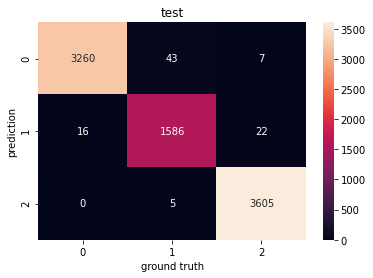

In [16]:
test_loader = DataLoader(train_set, batch_size=50, collate_fn=create_mini_batch)
%time x, y = test(test_loader)
print(classification_report(x, y, target_names=[str(i) for i in range(NUM_LABLES)]))
draw_c_matrix(confusion_matrix(x, y))

In [17]:
# test_loader = DataLoader(amazon_20201210_test_set, batch_size=50, collate_fn=create_mini_batch)
# %time x, y = test(test_loader)
# print(classification_report(x, y, target_names=[str(i) for i in range(NUM_LABLES)]))
# draw_c_matrix(confusion_matrix(x, y))

Wall time: 9.09 s
              precision    recall  f1-score   support

           0       0.84      0.67      0.74       912
           1       0.35      0.50      0.41       389
           2       0.83      0.85      0.84       909

    accuracy                           0.71      2210
   macro avg       0.67      0.67      0.67      2210
weighted avg       0.75      0.71      0.73      2210



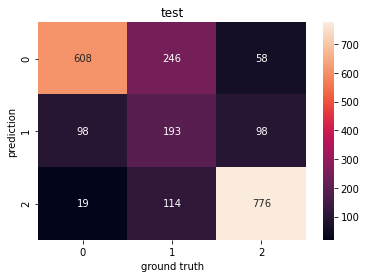

In [18]:
test_loader = DataLoader(sst5_test_set, batch_size=50, collate_fn=create_mini_batch, shuffle = True)
%time x, y = test(test_loader)
print(classification_report(x, y, target_names=[str(i) for i in range(NUM_LABLES)]))
draw_c_matrix(confusion_matrix(x, y))

# predict

In [21]:
load_model('3-sst5-'+NAME+'.pkl')

In [22]:
predict("Not as extreme as touted", TOKENIZER) #3/5

(tensor([1], device='cuda:0'),
 tensor([[ 2.7974,  3.1457, -2.7067]], device='cuda:0'))

In [23]:
predict("IT WAS DIFFERENT TYPE MOVIE BUT IT WAS GOOD. SUSPENSEFUL.", TOKENIZER) #5/5

(tensor([2], device='cuda:0'),
 tensor([[-4.4115,  1.3970,  5.0609]], device='cuda:0'))

In [24]:
predict("Not impressed with this movie, too many unknown variables.", TOKENIZER) #1/5

(tensor([0], device='cuda:0'),
 tensor([[ 5.0117,  0.4995, -2.3654]], device='cuda:0'))

In [25]:
predict("The first half is outstanding. Lupita Nyongo is excellent as always -- shes a moody complex character which makes complete sense after the big reveal.Once that big reveal happens, suspending disbelief is difficult, even for a horror movie. It is almost as if they came up with the main premise, than spit-balled an explanation. The explanation / back story is so absurd it requires way too much exposition. Heres hoping Peele gets more grounded in his third act.", TOKENIZER) #3/5

(tensor([1], device='cuda:0'),
 tensor([[0.3257, 0.8223, 0.3000]], device='cuda:0'))

In [26]:
predict("The ATE and APC subtasks were treated as independent tasks in previous studies. Moreover, the multi-tasklearning model for ATE and APC subtasks has not attracted enough attention from researchers.", TOKENIZER)

(tensor([0], device='cuda:0'),
 tensor([[ 3.5828,  3.3151, -3.6517]], device='cuda:0'))